In [76]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import transform

from shapely.geometry import Point, Polygon
import datetime

from io import StringIO
from pathlib import Path, PureWindowsPath
import os
import sys
from functools import partial

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location
from scripts.summary_stats import summary_stats

data_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets/")
shape_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Shared 228 Sydney Folder/SA2 Shapefiles/")
dv_analysis_path =  Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Shared 228 Sydney Folder/AU Work/MasterTypologyFolder")
sa2_w_dv = pd.read_csv(dv_analysis_path/'dummies_t3_corridor.csv')

Wall time: 658 ms


In [2]:
def filter_and_home_assign(data, shapefile, lower, upper):
    """
    Find subset of data to analyze based on lower/upper bounds on tweets/user, 
    then add home locations.
    
    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id
    
    shapefile : gpd.GeoDataFrame
        Shapefile for tracts in tweets location.
        Must be in WGS84 (epsg:4326) format (to align with tweet lat/lon).
    
    lower, upper : int or float
        Lower (inclusive) and upper (exclusive) bounds on tweets/user.
        
    Returns
    -------
    filtered : gpd.GeoDataFrame
        Collection of tweets filtered by lower/upper and with tweet geographies.
        Contains new columns:
            - 'timestamp' : pd.Timestamp for time of tweet published
            - 'date' : date (int) of tweet published
            - 'hour' : 24-hour (int) of tweet published
            - 'home' : name of home location codigo (some may be NaN)
            - 'is_home' : boolean indicating whether tweet was made at home
    """
    # Filter based on lower and upper bound on tweets/user
    filtered = data.groupby('u_id').filter(lambda group: (len(group) >= lower) & (len(group) < upper))
    
    # Geometrize tweets (inplace) based on lat/lon
    filtered = geometrize_tweets(filtered)
    
    # Spatial join with tracts
    filtered = gpd.sjoin(filtered, shapefile, how='left', op='intersects')
    
    # Add datetime
    filtered['timestamp'] = pd.to_datetime(filtered['created_at'] // 1000, unit='s')
    filtered['date'] = filtered['timestamp'].dt.date
    filtered['hour'] = filtered['timestamp'].dt.hour
    
    # Add home location
    filtered['home'] = assign_home_location(filtered, SA2='SA2_MAIN16')
    filtered['is_home'] = filtered['SA2_MAIN16'] == filtered['home']
    
    return filtered

In [3]:
#read in the twitter data in box
au_twitter = pd.read_csv('C:\\Users\\emman\\box\\Twitter data\\Asia\\Sydney\\sydney.csv')

In [4]:
au_twitter.dropna(inplace=True)

In [5]:
au_twitter.head()

id    created_at  \
0  227410653344841728  1.343054e+12   
1  227395003947810817  1.343050e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
1    Optus在strathfield附近的基站是不是出故障了，各种network lost...   22230298   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   

           u_name  u_created_at  \
0     jcaldwellau  1.322231e+12   
1     McKay Wei   1.235797e+12   
2  Daniel Baluyot  1.237898e+12   
3        Menchita  1.275050e+12   
4           Julia  1.326568e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
1  I make things on the web. #SocialMediaEnthusia...               1023   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  
0       AUS   JCaldwellAu              339    151.219627    -33.878069  
1       AUS      McKayWei              850    151.089056    -33.869059  
2       AUS    jhimdaniel              152    150.947871    -33.798275  
3       AUS      Guizmito               91    151.178006    -33.809274  
4       AUS    justjuliac               68    151.222993    -33.912209

In [6]:
au_twitter.shape

(6450144, 14)

In [7]:
au_twitter['timestamp'] = pd.to_datetime(au_twitter['created_at'] // 1000, unit='s')
au_twitter['date'] = au_twitter['timestamp'].dt.date
au_twitter[['id', 'text', 'date','timestamp']].head()

id                                               text  \
0  227410653344841728  @DaintyAintMe one hyphenated word for you my l...   
1  227395003947810817    Optus在strathfield附近的基站是不是出故障了，各种network lost...   
2  227395554844483584  @heyfeebs nah it was at 2am... and hopefully n...   
3  227397391727333376  @JUSECALO @AndreaSernaRCN si el apuntador dict...   
4  227398082562768896  @nichteo1995 cause we didnt meet before I leav...   

         date           timestamp  
0  2012-07-23 2012-07-23 14:31:39  
1  2012-07-23 2012-07-23 13:29:28  
2  2012-07-23 2012-07-23 13:31:39  
3  2012-07-23 2012-07-23 13:38:57  
4  2012-07-23 2012-07-23 13:41:42

In [8]:
au_twitter['date'] = pd.to_datetime(au_twitter.date)

In [9]:
au_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6450144 entries, 0 to 7262132
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   id                 int64         
 1   created_at         float64       
 2   text               object        
 3   u_id               int64         
 4   u_name             object        
 5   u_created_at       float64       
 6   u_description      object        
 7   u_followers_count  int64         
 8   type               object        
 9   c_country          object        
 10  u_screen_name      object        
 11  u_friends_count    int64         
 12  location.lon       float64       
 13  location.lat       float64       
 14  timestamp          datetime64[ns]
 15  date               datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(4), object(6)
memory usage: 836.6+ MB


Let's give those lat long a specific geometry as a point value for later geospatial plotting

In [10]:
# Create a shapely.geometry.Point for each tweet
geometry = [Point(xy) for xy in zip(au_twitter['location.lon'], au_twitter['location.lat'])]
crs = {'init' :'epsg:4326'}

In [11]:
# Convert to GeoDataFrame, where each tweet's geometry is assigned to the lat/lon coords
twt_gdf = gpd.GeoDataFrame(au_twitter, crs=crs, geometry=geometry)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
print(twt_gdf.shape)
twt_gdf.head()

(6450144, 17)


id    created_at  \
0  227410653344841728  1.343054e+12   
1  227395003947810817  1.343050e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
1    Optus在strathfield附近的基站是不是出故障了，各种network lost...   22230298   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   

           u_name  u_created_at  \
0     jcaldwellau  1.322231e+12   
1     McKay Wei   1.235797e+12   
2  Daniel Baluyot  1.237898e+12   
3        Menchita  1.275050e+12   
4           Julia  1.326568e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
1  I make things on the web. #SocialMediaEnthusia...               1023   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  \
0       AUS   JCaldwellAu              339    151.219627    -33.878069   
1       AUS      McKayWei              850    151.089056    -33.869059   
2       AUS    jhimdaniel              152    150.947871    -33.798275   
3       AUS      Guizmito               91    151.178006    -33.809274   
4       AUS    justjuliac               68    151.222993    -33.912209   

            timestamp       date                     geometry  
0 2012-07-23 14:31:39 2012-07-23  POINT (151.21963 -33.87807)  
1 2012-07-23 13:29:28 2012-07-23  POINT (151.08906 -33.86906)  
2 2012-07-23 13:31:39 2012-07-23  POINT (150.94787 -33.79827)  
3 2012-07-23 13:38:57 2012-07-23  POINT (151.17801 -33.80927)  
4 2012-07-23 13:41:42 2012-07-23  POINT (151.22299 -33.91221)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


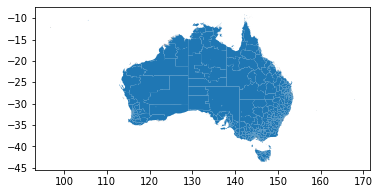

In [13]:
# Read Australia SA2 shapefiles
au_shape_sa2 = gpd.read_file('C:\\Users\\emman\\box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\SA2 Shapefiles\\SA2_2016_AUST.dbf')
# Crikey, our area is too big
au_shape_sa2.plot()
# We also need to change the crs 
au_shape_sa2.crs = {'init': 'epsg:4326'}

In [14]:
# have the shapefile only have areas that are in the state of New South Wales, and furthermore, in Greater Sydney
au_shape_sa2 = au_shape_sa2[au_shape_sa2.STE_NAME16 == 'New South Wales']

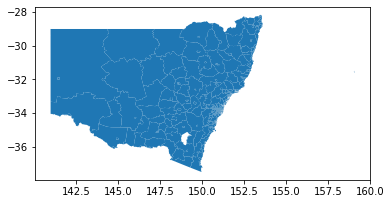

In [15]:
au_shape_sa2.plot()

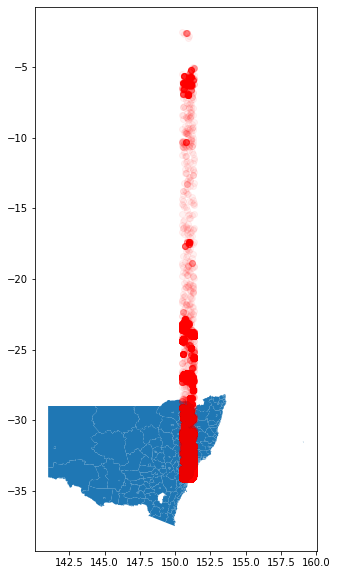

In [16]:
fig, ax = plt.subplots(figsize=(14, 10))
au_shape_sa2['geometry'].plot(ax=ax)
twt_gdf.plot(ax=ax, marker='o', color='red', alpha=0.05);

Hey, that's really stupid and uninformative. Maybe there's a better way?

In [17]:
au_shape_sa2.dropna(inplace=True)

In [18]:
twt_gdf_sub = twt_gdf[500:1000]

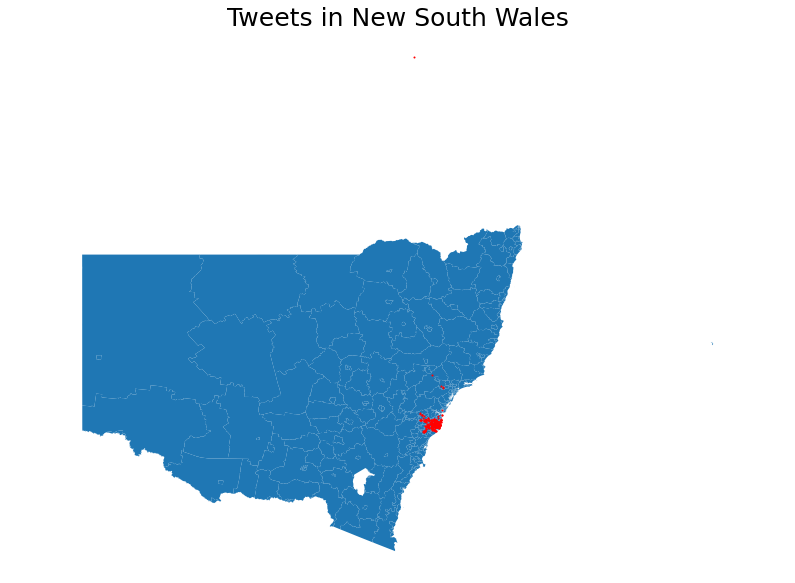

In [19]:
figure, ax = plt.subplots(figsize=(14,10))
base = au_shape_sa2.plot(ax=ax)
twt_gdf_sub.plot(ax=base, markersize=1, color="Red")
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Tweets in New South Wales', fontdict= 
            {'fontsize':25})

plt.show()

This is still pretty stupid and uninformative, but at least it's a bit bigger! Maybe we can work on a spatial join so that we can get the tweets that fall just outside of Greater Sydney removed from our dataset

In [20]:
twtsa2_gdf = gpd.sjoin(twt_gdf,au_shape_sa2,how='left',op='within')

In [21]:
twtsa2_gdf.drop('index_right',axis=1)
twtsa2_gdf.head()

id    created_at  \
0  227410653344841728  1.343054e+12   
1  227395003947810817  1.343050e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
1    Optus在strathfield附近的基站是不是出故障了，各种network lost...   22230298   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   

           u_name  u_created_at  \
0     jcaldwellau  1.322231e+12   
1     McKay Wei   1.235797e+12   
2  Daniel Baluyot  1.237898e+12   
3        Menchita  1.275050e+12   
4           Julia  1.326568e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
1  I make things on the web. #SocialMediaEnthusia...               1023   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  \
0       AUS   JCaldwellAu              339    151.219627    -33.878069   
1       AUS      McKayWei              850    151.089056    -33.869059   
2       AUS    jhimdaniel              152    150.947871    -33.798275   
3       AUS      Guizmito               91    151.178006    -33.809274   
4       AUS    justjuliac               68    151.222993    -33.912209   

            timestamp       date                     geometry  index_right  \
0 2012-07-23 14:31:39 2012-07-23  POINT (151.21963 -33.87807)        339.0   
1 2012-07-23 13:29:28 2012-07-23  POINT (151.08906 -33.86906)        413.0   
2 2012-07-23 13:31:39 2012-07-23  POINT (150.94787 -33.79827)        518.0   
3 2012-07-23 13:38:57 2012-07-23  POINT (151.17801 -33.80927)        416.0   
4 2012-07-23 13:41:42 2012-07-23  POINT (151.22299 -33.91221)        360.0   

  SA2_MAIN16 SA2_5DIG16                          SA2_NAME16 SA3_CODE16  \
0  117031329      11329                        Darlinghurst      11703   
1  120031575      11575                         Strathfield      12003   
2  125041588      11588             Pendle Hill - Girraween      12504   
3  121011399      11399  Chatswood (West) - Lane Cove North      12101   
4  118021564      11564                    Kensington (NSW)      11802   

                         SA3_NAME16 SA4_CODE16  \
0                 Sydney Inner City        117   
1  Strathfield - Burwood - Ashfield        120   
2                        Parramatta        125   
3             Chatswood - Lane Cove        121   
4           Eastern Suburbs - South        118   

                          SA4_NAME16 GCC_CODE16      GCC_NAME16 STE_CODE16  \
0      Sydney - City and Inner South      1GSYD  Greater Sydney          1   
1                Sydney - Inner West      1GSYD  Greater Sydney          1   
2                Sydney - Parramatta      1GSYD  Greater Sydney          1   
3  Sydney - North Sydney and Hornsby      1GSYD  Greater Sydney          1   
4           Sydney - Eastern Suburbs      1GSYD  Greater Sydney          1   

        STE_NAME16  AREASQKM16  
0  New South Wales      0.8569  
1  New South Wales      6.4515  
2  New South Wales      4.4615  
3  New South Wales      5.5372  
4  New South Wales      2.6422

In [22]:
twtsa2_gdf = twtsa2_gdf[twtsa2_gdf.STE_NAME16=='New South Wales']

In [23]:
twtsa2_gdf.shape

(6261909, 30)

In [24]:
twtsa2_gdf = twtsa2_gdf[twtsa2_gdf.GCC_NAME16=='Greater Sydney']

In [25]:
au_shape_sa2 = au_shape_sa2[au_shape_sa2.GCC_NAME16=='Greater Sydney']

In [26]:
twtsa2_gdf.shape

(6178094, 30)

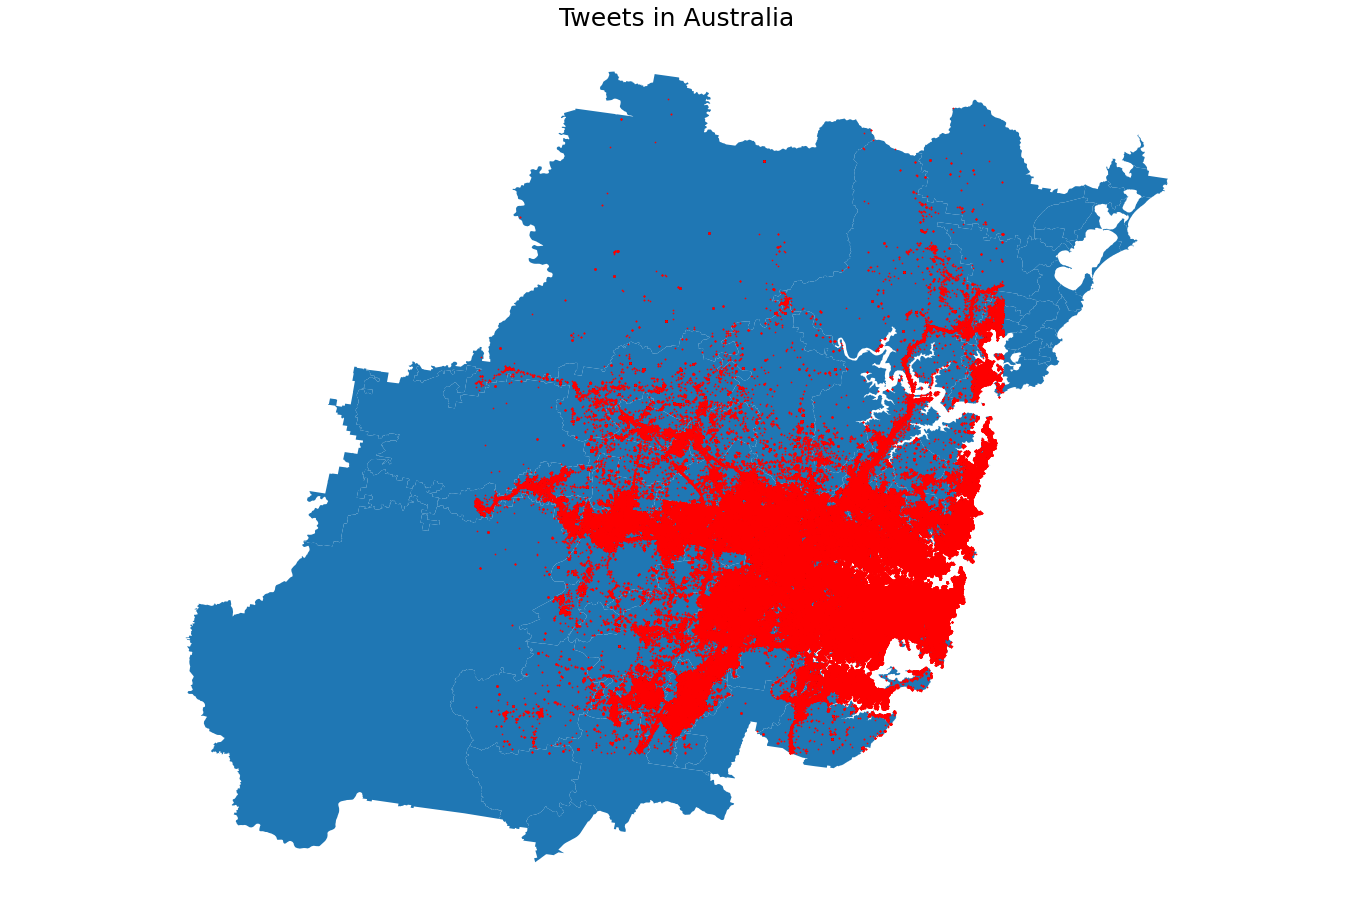

In [27]:
figure, ax = plt.subplots(figsize=(24,16))
base = au_shape_sa2.plot(ax=ax)
twtsa2_gdf.plot(ax=base, markersize=.5, color="Red")
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Tweets in Australia', fontdict= 
            {'fontsize':25})

plt.show()

In [28]:
# Select only users with greater than 20 tweets
df_20 = twtsa2_gdf.groupby('u_id').filter(lambda group: len(group) > 20)

print(df_20.shape)
df_20.head()

(5672392, 30)


id    created_at  \
0  227410653344841728  1.343054e+12   
1  227395003947810817  1.343050e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
1    Optus在strathfield附近的基站是不是出故障了，各种network lost...   22230298   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   

           u_name  u_created_at  \
0     jcaldwellau  1.322231e+12   
1     McKay Wei   1.235797e+12   
2  Daniel Baluyot  1.237898e+12   
3        Menchita  1.275050e+12   
4           Julia  1.326568e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
1  I make things on the web. #SocialMediaEnthusia...               1023   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  \
0       AUS   JCaldwellAu              339    151.219627    -33.878069   
1       AUS      McKayWei              850    151.089056    -33.869059   
2       AUS    jhimdaniel              152    150.947871    -33.798275   
3       AUS      Guizmito               91    151.178006    -33.809274   
4       AUS    justjuliac               68    151.222993    -33.912209   

            timestamp       date                     geometry  index_right  \
0 2012-07-23 14:31:39 2012-07-23  POINT (151.21963 -33.87807)        339.0   
1 2012-07-23 13:29:28 2012-07-23  POINT (151.08906 -33.86906)        413.0   
2 2012-07-23 13:31:39 2012-07-23  POINT (150.94787 -33.79827)        518.0   
3 2012-07-23 13:38:57 2012-07-23  POINT (151.17801 -33.80927)        416.0   
4 2012-07-23 13:41:42 2012-07-23  POINT (151.22299 -33.91221)        360.0   

  SA2_MAIN16 SA2_5DIG16                          SA2_NAME16 SA3_CODE16  \
0  117031329      11329                        Darlinghurst      11703   
1  120031575      11575                         Strathfield      12003   
2  125041588      11588             Pendle Hill - Girraween      12504   
3  121011399      11399  Chatswood (West) - Lane Cove North      12101   
4  118021564      11564                    Kensington (NSW)      11802   

                         SA3_NAME16 SA4_CODE16  \
0                 Sydney Inner City        117   
1  Strathfield - Burwood - Ashfield        120   
2                        Parramatta        125   
3             Chatswood - Lane Cove        121   
4           Eastern Suburbs - South        118   

                          SA4_NAME16 GCC_CODE16      GCC_NAME16 STE_CODE16  \
0      Sydney - City and Inner South      1GSYD  Greater Sydney          1   
1                Sydney - Inner West      1GSYD  Greater Sydney          1   
2                Sydney - Parramatta      1GSYD  Greater Sydney          1   
3  Sydney - North Sydney and Hornsby      1GSYD  Greater Sydney          1   
4           Sydney - Eastern Suburbs      1GSYD  Greater Sydney          1   

        STE_NAME16  AREASQKM16  
0  New South Wales      0.8569  
1  New South Wales      6.4515  
2  New South Wales      4.4615  
3  New South Wales      5.5372  
4  New South Wales      2.6422

# Extract home location

## Ate's methodology for extracting home location:

1. Consider tracts satisfying the following properties:
 * More than 10 tweets total
 * Sent from more than 10 different days
 * Sent from more than 8 different hours of the day
2. Of the remaining candidates, select the tract with the most tweets



### 1a. More than 10 tweets total¶

Explanation of code below:

1. From our data
2. Group by user u_id and tract OBJECTID (assumed to be the tract ID)
3. Select only the user-tract combinations for which there are more than MIN_TWEETS tweets (i.e. for each user, select only the tracts with more than MIN_TWEETS tweets)

In [29]:
df_sample = df_20[:100000]

In [30]:
# This value should be adjusted when using the entire dataset
MIN_TWEETS = 2

output_1a = (
    df_sample # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: len(user_tract) > MIN_TWEETS) # (3)
)

In [31]:
print(output_1a.shape)
output_1a.head()

(81979, 30)


id    created_at  \
0  227410653344841728  1.343054e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   
5  227394131700363265  1.343050e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   
5  Bsok bangun pagi lagi nganter adik lagi. Oh pl...   42222507   

               u_name  u_created_at  \
0         jcaldwellau  1.322231e+12   
2      Daniel Baluyot  1.237898e+12   
3            Menchita  1.275050e+12   
4               Julia  1.326568e+12   
5  Riastini Ratnasari  1.243177e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   
5  ☮ I am an happilionaire ;DDDD\nAm blessed and ...               1008   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  \
0       AUS   JCaldwellAu              339    151.219627    -33.878069   
2       AUS    jhimdaniel              152    150.947871    -33.798275   
3       AUS      Guizmito               91    151.178006    -33.809274   
4       AUS    justjuliac               68    151.222993    -33.912209   
5       AUS       gektien              415    151.109044    -33.770251   

            timestamp       date                     geometry  index_right  \
0 2012-07-23 14:31:39 2012-07-23  POINT (151.21963 -33.87807)        339.0   
2 2012-07-23 13:31:39 2012-07-23  POINT (150.94787 -33.79827)        518.0   
3 2012-07-23 13:38:57 2012-07-23  POINT (151.17801 -33.80927)        416.0   
4 2012-07-23 13:41:42 2012-07-23  POINT (151.22299 -33.91221)        360.0   
5 2012-07-23 13:26:00 2012-07-23  POINT (151.10904 -33.77025)        525.0   

  SA2_MAIN16 SA2_5DIG16                          SA2_NAME16 SA3_CODE16  \
0  117031329      11329                        Darlinghurst      11703   
2  125041588      11588             Pendle Hill - Girraween      12504   
3  121011399      11399  Chatswood (West) - Lane Cove North      12101   
4  118021564      11564                    Kensington (NSW)      11802   
5  126021500      11500          Macquarie Park - Marsfield      12602   

                SA3_NAME16 SA4_CODE16                         SA4_NAME16  \
0        Sydney Inner City        117      Sydney - City and Inner South   
2               Parramatta        125                Sydney - Parramatta   
3    Chatswood - Lane Cove        121  Sydney - North Sydney and Hornsby   
4  Eastern Suburbs - South        118           Sydney - Eastern Suburbs   
5      Ryde - Hunters Hill        126                      Sydney - Ryde   

  GCC_CODE16      GCC_NAME16 STE_CODE16       STE_NAME16  AREASQKM16  
0      1GSYD  Greater Sydney          1  New South Wales      0.8569  
2      1GSYD  Greater Sydney          1  New South Wales      4.4615  
3      1GSYD  Greater Sydney          1  New South Wales      5.5372  
4      1GSYD  Greater Sydney          1  New South Wales      2.6422  
5      1GSYD  Greater Sydney          1  New South Wales     10.6720

In [32]:
# Sanity check
# Check documentation for asserthttps://www.tutorialspoint.com/python/assertions_in_python.htm
assert all(output_1a.groupby(['u_id', 'SA2_5DIG16']).size() > MIN_TWEETS)

## 1b. Sent from more than 10 days

In [33]:
# First, some cleaning: extract timestamp from tweet data.
# Each tweet is recorded in UNIX time, and (for some reason) multiplied by 1000
output_1a['timestamp'] = pd.to_datetime(output_1a['created_at'] // 1000, unit='s')
output_1a['date'] = output_1a['timestamp'].dt.date

output_1a[['id', 'text', 'date','timestamp']].head()

id                                               text  \
0  227410653344841728  @DaintyAintMe one hyphenated word for you my l...   
2  227395554844483584  @heyfeebs nah it was at 2am... and hopefully n...   
3  227397391727333376  @JUSECALO @AndreaSernaRCN si el apuntador dict...   
4  227398082562768896  @nichteo1995 cause we didnt meet before I leav...   
5  227394131700363265  Bsok bangun pagi lagi nganter adik lagi. Oh pl...   

         date           timestamp  
0  2012-07-23 2012-07-23 14:31:39  
2  2012-07-23 2012-07-23 13:31:39  
3  2012-07-23 2012-07-23 13:38:57  
4  2012-07-23 2012-07-23 13:41:42  
5  2012-07-23 2012-07-23 13:26:00

Explanation of code below:

1. From our data
2. Group by user u_id and SA2 MAINCODE
3. Select user-SA2 combinations for which there are more than MIN_DAYS unique dates

In [34]:
# This value should be adjusted when using the full dataset
MIN_DAYS = 2

output_1b = (
    output_1a # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['date'].nunique() > MIN_DAYS) # (3)
)

In [35]:
print(output_1b.shape)
output_1b.head()

(74411, 30)


id    created_at  \
0  227410653344841728  1.343054e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   
5  227394131700363265  1.343050e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   
5  Bsok bangun pagi lagi nganter adik lagi. Oh pl...   42222507   

               u_name  u_created_at  \
0         jcaldwellau  1.322231e+12   
2      Daniel Baluyot  1.237898e+12   
3            Menchita  1.275050e+12   
4               Julia  1.326568e+12   
5  Riastini Ratnasari  1.243177e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   
5  ☮ I am an happilionaire ;DDDD\nAm blessed and ...               1008   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  \
0       AUS   JCaldwellAu              339    151.219627    -33.878069   
2       AUS    jhimdaniel              152    150.947871    -33.798275   
3       AUS      Guizmito               91    151.178006    -33.809274   
4       AUS    justjuliac               68    151.222993    -33.912209   
5       AUS       gektien              415    151.109044    -33.770251   

            timestamp        date                     geometry  index_right  \
0 2012-07-23 14:31:39  2012-07-23  POINT (151.21963 -33.87807)        339.0   
2 2012-07-23 13:31:39  2012-07-23  POINT (150.94787 -33.79827)        518.0   
3 2012-07-23 13:38:57  2012-07-23  POINT (151.17801 -33.80927)        416.0   
4 2012-07-23 13:41:42  2012-07-23  POINT (151.22299 -33.91221)        360.0   
5 2012-07-23 13:26:00  2012-07-23  POINT (151.10904 -33.77025)        525.0   

  SA2_MAIN16 SA2_5DIG16                          SA2_NAME16 SA3_CODE16  \
0  117031329      11329                        Darlinghurst      11703   
2  125041588      11588             Pendle Hill - Girraween      12504   
3  121011399      11399  Chatswood (West) - Lane Cove North      12101   
4  118021564      11564                    Kensington (NSW)      11802   
5  126021500      11500          Macquarie Park - Marsfield      12602   

                SA3_NAME16 SA4_CODE16                         SA4_NAME16  \
0        Sydney Inner City        117      Sydney - City and Inner South   
2               Parramatta        125                Sydney - Parramatta   
3    Chatswood - Lane Cove        121  Sydney - North Sydney and Hornsby   
4  Eastern Suburbs - South        118           Sydney - Eastern Suburbs   
5      Ryde - Hunters Hill        126                      Sydney - Ryde   

  GCC_CODE16      GCC_NAME16 STE_CODE16       STE_NAME16  AREASQKM16  
0      1GSYD  Greater Sydney          1  New South Wales      0.8569  
2      1GSYD  Greater Sydney          1  New South Wales      4.4615  
3      1GSYD  Greater Sydney          1  New South Wales      5.5372  
4      1GSYD  Greater Sydney          1  New South Wales      2.6422  
5      1GSYD  Greater Sydney          1  New South Wales     10.6720

In [36]:
# Sanity check
assert all(output_1b.groupby(['u_id', 'SA2_5DIG16'])['date'].nunique() > MIN_DAYS)

### 1c. Sent from more than 8 different hours of the day

In [37]:
output_1b['hour'] = output_1b['timestamp'].dt.hour
output_1b[['id', 'text', 'hour']].head()

id                                               text  hour
0  227410653344841728  @DaintyAintMe one hyphenated word for you my l...    14
2  227395554844483584  @heyfeebs nah it was at 2am... and hopefully n...    13
3  227397391727333376  @JUSECALO @AndreaSernaRCN si el apuntador dict...    13
4  227398082562768896  @nichteo1995 cause we didnt meet before I leav...    13
5  227394131700363265  Bsok bangun pagi lagi nganter adik lagi. Oh pl...    13

Explanation of code below:

1. From our data
2. Group by user u_id and SA2 MAINCODE
3. Select user-tract combinations for which there are more than MIN_HOURS unique hours

In [38]:
# This value should be adjusted when using the full dataset
MIN_HOURS = 4

output_1c = (
    output_1b # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['hour'].nunique() > MIN_HOURS) # (3)
)

In [39]:
print(output_1c.shape)
output_1c.head()

(63758, 31)


id    created_at  \
0  227410653344841728  1.343054e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   
5  227394131700363265  1.343050e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   
5  Bsok bangun pagi lagi nganter adik lagi. Oh pl...   42222507   

               u_name  u_created_at  \
0         jcaldwellau  1.322231e+12   
2      Daniel Baluyot  1.237898e+12   
3            Menchita  1.275050e+12   
4               Julia  1.326568e+12   
5  Riastini Ratnasari  1.243177e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   
5  ☮ I am an happilionaire ;DDDD\nAm blessed and ...               1008   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  \
0       AUS   JCaldwellAu              339    151.219627    -33.878069   
2       AUS    jhimdaniel              152    150.947871    -33.798275   
3       AUS      Guizmito               91    151.178006    -33.809274   
4       AUS    justjuliac               68    151.222993    -33.912209   
5       AUS       gektien              415    151.109044    -33.770251   

            timestamp        date                     geometry  index_right  \
0 2012-07-23 14:31:39  2012-07-23  POINT (151.21963 -33.87807)        339.0   
2 2012-07-23 13:31:39  2012-07-23  POINT (150.94787 -33.79827)        518.0   
3 2012-07-23 13:38:57  2012-07-23  POINT (151.17801 -33.80927)        416.0   
4 2012-07-23 13:41:42  2012-07-23  POINT (151.22299 -33.91221)        360.0   
5 2012-07-23 13:26:00  2012-07-23  POINT (151.10904 -33.77025)        525.0   

  SA2_MAIN16 SA2_5DIG16                          SA2_NAME16 SA3_CODE16  \
0  117031329      11329                        Darlinghurst      11703   
2  125041588      11588             Pendle Hill - Girraween      12504   
3  121011399      11399  Chatswood (West) - Lane Cove North      12101   
4  118021564      11564                    Kensington (NSW)      11802   
5  126021500      11500          Macquarie Park - Marsfield      12602   

                SA3_NAME16 SA4_CODE16                         SA4_NAME16  \
0        Sydney Inner City        117      Sydney - City and Inner South   
2               Parramatta        125                Sydney - Parramatta   
3    Chatswood - Lane Cove        121  Sydney - North Sydney and Hornsby   
4  Eastern Suburbs - South        118           Sydney - Eastern Suburbs   
5      Ryde - Hunters Hill        126                      Sydney - Ryde   

  GCC_CODE16      GCC_NAME16 STE_CODE16       STE_NAME16  AREASQKM16  hour  
0      1GSYD  Greater Sydney          1  New South Wales      0.8569    14  
2      1GSYD  Greater Sydney          1  New South Wales      4.4615    13  
3      1GSYD  Greater Sydney          1  New South Wales      5.5372    13  
4      1GSYD  Greater Sydney          1  New South Wales      2.6422    13  
5      1GSYD  Greater Sydney          1  New South Wales     10.6720    13

In [40]:
# Sanity check
assert all(output_1c.groupby(['u_id', 'SA2_5DIG16'])['hour'].nunique() > MIN_HOURS)

## 2. Of the remaining candidates, select the tract with the most tweets

In [41]:
# View number of tweets per user per tract
output_1c.groupby(['u_id', 'SA2_5DIG16']).size()

u_id       SA2_5DIG16
7512       11422         13
           11423          8
10706      11326         14
           11336         12
           11337         16
                         ..
778161258  11306         19
799942494  11582          7
           11583         10
803871120  11348         15
821041466  11369         31
Length: 2418, dtype: int64

It looks to be the case that there are some users that have more than one tract satisfying all three constraints specified in 1a-1c. Thus for all users, we select the most frequent tract.

Explanation of code below:

1. From our data
2. Group by user u_id and tract SA2_5DIG16
3. Find the number of observations in each user-tract combination
4. Name the resulting pd.Series count, then convert into a pd.DataFrame
5. At this point, we have a DataFrame with each row representing one user-tract combination. There are three variables: u_id, SA2_5DIG16, and count (which represents the number of tweets recorded at the user-tract combination). Sort the rows in descending order by count, so that the first row that a given u_id appears corresponds to the SA2_5DIG16 for which it has the most tweets.
6. Select the u_id and OBJECTID columns in preparation for grouping.
7. Group by u_id so that each group represents a user, and each observation inside the group is an OBJECTID. The ordering should still stay consistent with step 5, i.e. the first observation in each group corresponds to the OBJECTID at which the user tweeted the most.
8. Select that first observation, to result in the DataFrame shown below
9. Rename column for convenience
10. Convert into pd.Series for convenience

In [42]:
home_locations = (
    output_1c # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .size() # (3)
    .reset_index(name='count') # (4)
    .sort_values('count', ascending=False) # (5)
    .loc[:, ['u_id', 'SA2_5DIG16']] # (6)
    .groupby('u_id') # (7)
    .first() # (8)
    .rename(columns={'SA2_5DIG16':'home_sa2'}) # (9)
    .loc[:, 'home_sa2'] # (10)
)

In [43]:
# Sanity check: We should have one home location for each unique user in output_1c 
assert len(home_locations) == output_1c['u_id'].nunique()

In [44]:
# Assign each tweet a home_tract based on home_locations
# Using .map is orders of magnitudes faster than using a join
df_sample['home_sa2'] = df_sample['u_id'].map(home_locations.to_dict())

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
# Preprocessing necessary for function
df_sample['timestamp'] = pd.to_datetime(df_sample['created_at'] // 1000, unit='s')
df_sample['date'] = df_sample['timestamp'].dt.date
df_sample['hour'] = df_sample['timestamp'].dt.hour
df_sample['SA2_5DIG16'].astype(str)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

0         11329
1         11575
2         11588
3         11399
4         11564
          ...  
132586    11391
132587    11345
132588    11331
132589    11591
132591    11387
Name: SA2_5DIG16, Length: 100000, dtype: object

In [46]:
df_sample['home_sa2'] = assign_home_location(df_sample, min_tweets=MIN_TWEETS, min_days=MIN_DAYS, min_hours=MIN_HOURS)
df_sample['home_sa2']

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0         117031329
1         117031334
2         125041588
3         121011399
4         118021564
            ...    
132586    117031332
132587    118011345
132588    117031334
132589    126021591
132591          NaN
Name: home_sa2, Length: 100000, dtype: object

In [47]:
df_sample['home_sa2'].isnull().sum()

19756

About 20% of our sample data is not assigned a home location; this is because that user's tweets were all filtered out in part 1a-1c. It remains to be seen how this proportion may change for the entire set of data (as opposed to the sample of 100,000 observations).

# Running the full dataset through home location code:

In [48]:
# This value should be adjusted when using the entire dataset
MIN_TWEETS = 2

output_1a = (
    twtsa2_gdf # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: len(user_tract) > MIN_TWEETS) # (3)
)

In [49]:
print(output_1a.shape)
output_1a.head()

(5660037, 30)


id    created_at  \
0  227410653344841728  1.343054e+12   
1  227395003947810817  1.343050e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
1    Optus在strathfield附近的基站是不是出故障了，各种network lost...   22230298   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   

           u_name  u_created_at  \
0     jcaldwellau  1.322231e+12   
1     McKay Wei   1.235797e+12   
2  Daniel Baluyot  1.237898e+12   
3        Menchita  1.275050e+12   
4           Julia  1.326568e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
1  I make things on the web. #SocialMediaEnthusia...               1023   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  \
0       AUS   JCaldwellAu              339    151.219627    -33.878069   
1       AUS      McKayWei              850    151.089056    -33.869059   
2       AUS    jhimdaniel              152    150.947871    -33.798275   
3       AUS      Guizmito               91    151.178006    -33.809274   
4       AUS    justjuliac               68    151.222993    -33.912209   

            timestamp       date                     geometry  index_right  \
0 2012-07-23 14:31:39 2012-07-23  POINT (151.21963 -33.87807)        339.0   
1 2012-07-23 13:29:28 2012-07-23  POINT (151.08906 -33.86906)        413.0   
2 2012-07-23 13:31:39 2012-07-23  POINT (150.94787 -33.79827)        518.0   
3 2012-07-23 13:38:57 2012-07-23  POINT (151.17801 -33.80927)        416.0   
4 2012-07-23 13:41:42 2012-07-23  POINT (151.22299 -33.91221)        360.0   

  SA2_MAIN16 SA2_5DIG16                          SA2_NAME16 SA3_CODE16  \
0  117031329      11329                        Darlinghurst      11703   
1  120031575      11575                         Strathfield      12003   
2  125041588      11588             Pendle Hill - Girraween      12504   
3  121011399      11399  Chatswood (West) - Lane Cove North      12101   
4  118021564      11564                    Kensington (NSW)      11802   

                         SA3_NAME16 SA4_CODE16  \
0                 Sydney Inner City        117   
1  Strathfield - Burwood - Ashfield        120   
2                        Parramatta        125   
3             Chatswood - Lane Cove        121   
4           Eastern Suburbs - South        118   

                          SA4_NAME16 GCC_CODE16      GCC_NAME16 STE_CODE16  \
0      Sydney - City and Inner South      1GSYD  Greater Sydney          1   
1                Sydney - Inner West      1GSYD  Greater Sydney          1   
2                Sydney - Parramatta      1GSYD  Greater Sydney          1   
3  Sydney - North Sydney and Hornsby      1GSYD  Greater Sydney          1   
4           Sydney - Eastern Suburbs      1GSYD  Greater Sydney          1   

        STE_NAME16  AREASQKM16  
0  New South Wales      0.8569  
1  New South Wales      6.4515  
2  New South Wales      4.4615  
3  New South Wales      5.5372  
4  New South Wales      2.6422

In [50]:
# Sanity check
# Check documentation for asserthttps://www.tutorialspoint.com/python/assertions_in_python.htm
assert all(output_1a.groupby(['u_id', 'SA2_5DIG16']).size() > MIN_TWEETS)

In [51]:
# First, some cleaning: extract timestamp from tweet data.
# Each tweet is recorded in UNIX time, and (for some reason) multiplied by 1000
output_1a['timestamp'] = pd.to_datetime(output_1a['created_at'] // 1000, unit='s')
output_1a['date'] = output_1a['timestamp'].dt.date

output_1a[['id', 'text', 'date','timestamp']].head()

id                                               text  \
0  227410653344841728  @DaintyAintMe one hyphenated word for you my l...   
1  227395003947810817    Optus在strathfield附近的基站是不是出故障了，各种network lost...   
2  227395554844483584  @heyfeebs nah it was at 2am... and hopefully n...   
3  227397391727333376  @JUSECALO @AndreaSernaRCN si el apuntador dict...   
4  227398082562768896  @nichteo1995 cause we didnt meet before I leav...   

         date           timestamp  
0  2012-07-23 2012-07-23 14:31:39  
1  2012-07-23 2012-07-23 13:29:28  
2  2012-07-23 2012-07-23 13:31:39  
3  2012-07-23 2012-07-23 13:38:57  
4  2012-07-23 2012-07-23 13:41:42

In [52]:
# This value should be adjusted when using the full dataset
MIN_DAYS = 2

output_1b = (
    output_1a # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['date'].nunique() > MIN_DAYS) # (3)
)

In [53]:
print(output_1b.shape)
output_1b.head()

(5361600, 30)


id    created_at  \
0  227410653344841728  1.343054e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   
5  227394131700363265  1.343050e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   
5  Bsok bangun pagi lagi nganter adik lagi. Oh pl...   42222507   

               u_name  u_created_at  \
0         jcaldwellau  1.322231e+12   
2      Daniel Baluyot  1.237898e+12   
3            Menchita  1.275050e+12   
4               Julia  1.326568e+12   
5  Riastini Ratnasari  1.243177e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   
5  ☮ I am an happilionaire ;DDDD\nAm blessed and ...               1008   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  \
0       AUS   JCaldwellAu              339    151.219627    -33.878069   
2       AUS    jhimdaniel              152    150.947871    -33.798275   
3       AUS      Guizmito               91    151.178006    -33.809274   
4       AUS    justjuliac               68    151.222993    -33.912209   
5       AUS       gektien              415    151.109044    -33.770251   

            timestamp        date                     geometry  index_right  \
0 2012-07-23 14:31:39  2012-07-23  POINT (151.21963 -33.87807)        339.0   
2 2012-07-23 13:31:39  2012-07-23  POINT (150.94787 -33.79827)        518.0   
3 2012-07-23 13:38:57  2012-07-23  POINT (151.17801 -33.80927)        416.0   
4 2012-07-23 13:41:42  2012-07-23  POINT (151.22299 -33.91221)        360.0   
5 2012-07-23 13:26:00  2012-07-23  POINT (151.10904 -33.77025)        525.0   

  SA2_MAIN16 SA2_5DIG16                          SA2_NAME16 SA3_CODE16  \
0  117031329      11329                        Darlinghurst      11703   
2  125041588      11588             Pendle Hill - Girraween      12504   
3  121011399      11399  Chatswood (West) - Lane Cove North      12101   
4  118021564      11564                    Kensington (NSW)      11802   
5  126021500      11500          Macquarie Park - Marsfield      12602   

                SA3_NAME16 SA4_CODE16                         SA4_NAME16  \
0        Sydney Inner City        117      Sydney - City and Inner South   
2               Parramatta        125                Sydney - Parramatta   
3    Chatswood - Lane Cove        121  Sydney - North Sydney and Hornsby   
4  Eastern Suburbs - South        118           Sydney - Eastern Suburbs   
5      Ryde - Hunters Hill        126                      Sydney - Ryde   

  GCC_CODE16      GCC_NAME16 STE_CODE16       STE_NAME16  AREASQKM16  
0      1GSYD  Greater Sydney          1  New South Wales      0.8569  
2      1GSYD  Greater Sydney          1  New South Wales      4.4615  
3      1GSYD  Greater Sydney          1  New South Wales      5.5372  
4      1GSYD  Greater Sydney          1  New South Wales      2.6422  
5      1GSYD  Greater Sydney          1  New South Wales     10.6720

In [54]:
# Sanity check
assert all(output_1b.groupby(['u_id', 'SA2_5DIG16'])['date'].nunique() > MIN_DAYS)

In [55]:
output_1b['hour'] = output_1b['timestamp'].dt.hour
output_1b[['id', 'text', 'hour']].head()

id                                               text  hour
0  227410653344841728  @DaintyAintMe one hyphenated word for you my l...    14
2  227395554844483584  @heyfeebs nah it was at 2am... and hopefully n...    13
3  227397391727333376  @JUSECALO @AndreaSernaRCN si el apuntador dict...    13
4  227398082562768896  @nichteo1995 cause we didnt meet before I leav...    13
5  227394131700363265  Bsok bangun pagi lagi nganter adik lagi. Oh pl...    13

In [56]:
# This value should be adjusted when using the full dataset
MIN_HOURS = 4

output_1c = (
    output_1b # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['hour'].nunique() > MIN_HOURS) # (3)
)

In [57]:
print(output_1c.shape)
output_1c.head()

(5031683, 31)


id    created_at  \
0  227410653344841728  1.343054e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   
5  227394131700363265  1.343050e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   
5  Bsok bangun pagi lagi nganter adik lagi. Oh pl...   42222507   

               u_name  u_created_at  \
0         jcaldwellau  1.322231e+12   
2      Daniel Baluyot  1.237898e+12   
3            Menchita  1.275050e+12   
4               Julia  1.326568e+12   
5  Riastini Ratnasari  1.243177e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   
5  ☮ I am an happilionaire ;DDDD\nAm blessed and ...               1008   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  \
0       AUS   JCaldwellAu              339    151.219627    -33.878069   
2       AUS    jhimdaniel              152    150.947871    -33.798275   
3       AUS      Guizmito               91    151.178006    -33.809274   
4       AUS    justjuliac               68    151.222993    -33.912209   
5       AUS       gektien              415    151.109044    -33.770251   

            timestamp        date                     geometry  index_right  \
0 2012-07-23 14:31:39  2012-07-23  POINT (151.21963 -33.87807)        339.0   
2 2012-07-23 13:31:39  2012-07-23  POINT (150.94787 -33.79827)        518.0   
3 2012-07-23 13:38:57  2012-07-23  POINT (151.17801 -33.80927)        416.0   
4 2012-07-23 13:41:42  2012-07-23  POINT (151.22299 -33.91221)        360.0   
5 2012-07-23 13:26:00  2012-07-23  POINT (151.10904 -33.77025)        525.0   

  SA2_MAIN16 SA2_5DIG16                          SA2_NAME16 SA3_CODE16  \
0  117031329      11329                        Darlinghurst      11703   
2  125041588      11588             Pendle Hill - Girraween      12504   
3  121011399      11399  Chatswood (West) - Lane Cove North      12101   
4  118021564      11564                    Kensington (NSW)      11802   
5  126021500      11500          Macquarie Park - Marsfield      12602   

                SA3_NAME16 SA4_CODE16                         SA4_NAME16  \
0        Sydney Inner City        117      Sydney - City and Inner South   
2               Parramatta        125                Sydney - Parramatta   
3    Chatswood - Lane Cove        121  Sydney - North Sydney and Hornsby   
4  Eastern Suburbs - South        118           Sydney - Eastern Suburbs   
5      Ryde - Hunters Hill        126                      Sydney - Ryde   

  GCC_CODE16      GCC_NAME16 STE_CODE16       STE_NAME16  AREASQKM16  hour  
0      1GSYD  Greater Sydney          1  New South Wales      0.8569    14  
2      1GSYD  Greater Sydney          1  New South Wales      4.4615    13  
3      1GSYD  Greater Sydney          1  New South Wales      5.5372    13  
4      1GSYD  Greater Sydney          1  New South Wales      2.6422    13  
5      1GSYD  Greater Sydney          1  New South Wales     10.6720    13

In [58]:
# Sanity check
assert all(output_1c.groupby(['u_id', 'SA2_5DIG16'])['hour'].nunique() > MIN_HOURS)

In [59]:
# View number of tweets per user per tract
output_1c.groupby(['u_id', 'SA2_5DIG16']).size()

u_id                SA2_5DIG16
718                 11337            7
1952                11337           17
2624                11426            5
5177                11291           36
                    11302           18
                                  ... 
767145048957825024  11568           14
777436189649309696  11444           26
780476339916713985  11314         1750
                    11329          804
                    11337         4518
Length: 90103, dtype: int64

In [60]:
home_locations = (
    output_1c # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .size() # (3)
    .reset_index(name='count') # (4)
    .sort_values('count', ascending=False) # (5)
    .loc[:, ['u_id', 'SA2_5DIG16']] # (6)
    .groupby('u_id') # (7)
    .first() # (8)
    .rename(columns={'SA2_5DIG16':'home_sa2'}) # (9)
    .loc[:, 'home_sa2'] # (10)
)

In [61]:
# Sanity check: We should have one home location for each unique user in output_1c 
assert len(home_locations) == output_1c['u_id'].nunique()

In [62]:
# Assign each tweet a home_tract based on home_locations
# Using .map is orders of magnitudes faster than using a join
twtsa2_gdf['home_sa2'] = twtsa2_gdf['u_id'].map(home_locations.to_dict())

In [63]:
# Preprocessing necessary for function
twtsa2_gdf['timestamp'] = pd.to_datetime(twtsa2_gdf['created_at'] // 1000, unit='s')
twtsa2_gdf['date'] = twtsa2_gdf['timestamp'].dt.date
twtsa2_gdf['hour'] = twtsa2_gdf['timestamp'].dt.hour
twtsa2_gdf['SA2_5DIG16']= twtsa2_gdf['SA2_5DIG16'].astype(str)

In [64]:
twtsa2_gdf['home_sa2'] = assign_home_location(twtsa2_gdf, min_tweets=MIN_TWEETS, min_days=MIN_DAYS, min_hours=MIN_HOURS)
twtsa2_gdf['home_sa2']

0          116031316
1          121011398
2          125041588
3          121011400
4          118021564
             ...    
7262128    117031337
7262129    117031337
7262130    117031337
7262131    117031333
7262132    102011030
Name: home_sa2, Length: 6178094, dtype: object

In [65]:
twtsa2_gdf['home_sa2'].isnull().sum()

421266

In [66]:
#twtsa2_gdf.to_file("au_twitter.geojson", driver='GeoJSON')

In [67]:
#twtsa2_gdf.to_csv('au_twitter.csv')

In [115]:
autwt_2012 = au_twitter.loc[(au_twitter.date>='2012-01-01')&(au_twitter.date<'2013-01-01')]
autwt_2013 = au_twitter.loc[(au_twitter.date>='2013-01-01')&(au_twitter.date<='2014-01-01')]
autwt_2014 = au_twitter.loc[(au_twitter.date>='2014-01-01')&(au_twitter.date<='2015-01-01')]
autwt_2015 = au_twitter.loc[(au_twitter.date>='2015-01-01')&(au_twitter.date<='2016-01-01')]
autwt_2016 = au_twitter.loc[(au_twitter.date>='201-01-01')&(au_twitter.date<='2017-01-01')]

In [69]:
save_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Datasets/")

In [70]:
#autwt_2012.to_csv(save_path/'AUST_TWT_2012.csv')

In [71]:
#autwt_2013.to_csv(save_path/'AUST_TWT_2013.csv')

In [72]:
#autwt_2014.to_csv(save_path/'AUST_TWT_2014.csv')

In [73]:
#autwt_2015.to_csv(save_path/'AUST_TWT_2015.csv')

In [74]:
autwt_2016.to_csv(save_path/'AUST_TWT_2016.csv')

# Analysis of 2012 Home Locations 

2012 provided the most insight due to its proximity to the gentrification typology data that we were using from the 2011 census in Australia. Below, we'll see the spatial distribution of tweets that are joined with socioeconomic indicators to try and see where people from "disadvantaged" or "privileged" areas spend their time on social media. 

In [134]:
# Read Australia SA2 shapefiles sa2_ucl
syd_ucl_sa2 = gpd.read_file(shape_path/'sa2_ucl.dbf').copy()
# We also need to change the crs 
syd_ucl_sa2.crs = {'init': 'epsg:4326'}
# change the sa2_main16 ID to int
syd_ucl_sa2['SA2_MAIN16'] = syd_ucl_sa2['SA2_MAIN16'].astype(int)
# do the same for the case study area DVs
sa2_w_dv['SA2_MAIN16'] = sa2_w_dv['SA2_MAIN16'].astype(int)
# merge the two dataframes
syd_ucl_sa2 = pd.merge(syd_ucl_sa2, sa2_w_dv, how='left', on='SA2_MAIN16')
#drop variables
syd_ucl_sa2.drop('Unnamed: 0',axis=1,inplace=True)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [135]:
tweets_2012 = autwt_2012.copy()
tweets_2012.head()

id    created_at  \
0  227410653344841728  1.343054e+12   
1  227395003947810817  1.343050e+12   
2  227395554844483584  1.343050e+12   
3  227397391727333376  1.343051e+12   
4  227398082562768896  1.343051e+12   

                                                text       u_id  \
0  @DaintyAintMe one hyphenated word for you my l...  421108959   
1    Optus在strathfield附近的基站是不是出故障了，各种network lost...   22230298   
2  @heyfeebs nah it was at 2am... and hopefully n...   26226128   
3  @JUSECALO @AndreaSernaRCN si el apuntador dict...  149103289   
4  @nichteo1995 cause we didnt meet before I leav...  464020712   

           u_name  u_created_at  \
0     jcaldwellau  1.322231e+12   
1     McKay Wei   1.235797e+12   
2  Daniel Baluyot  1.237898e+12   
3        Menchita  1.275050e+12   
4           Julia  1.326568e+12   

                                       u_description  u_followers_count type  \
0  • Lascivious • Serial Flirt • Daring • Music l...               3877   ll   
1  I make things on the web. #SocialMediaEnthusia...               1023   ll   
2  17 year old Filipino, I'm a Sydneysider. I'll ...                148   ll   
3  Colombiana 100% paisa. Amo el cine, la buena c...                 16   ll   
4                             Done trusting people.                  69   ll   

  c_country u_screen_name  u_friends_count  location.lon  location.lat  \
0       AUS   JCaldwellAu              339    151.219627    -33.878069   
1       AUS      McKayWei              850    151.089056    -33.869059   
2       AUS    jhimdaniel              152    150.947871    -33.798275   
3       AUS      Guizmito               91    151.178006    -33.809274   
4       AUS    justjuliac               68    151.222993    -33.912209   

            timestamp       date                     geometry  
0 2012-07-23 14:31:39 2012-07-23  POINT (151.21963 -33.87807)  
1 2012-07-23 13:29:28 2012-07-23  POINT (151.08906 -33.86906)  
2 2012-07-23 13:31:39 2012-07-23  POINT (150.94787 -33.79827)  
3 2012-07-23 13:38:57 2012-07-23  POINT (151.17801 -33.80927)  
4 2012-07-23 13:41:42 2012-07-23  POINT (151.22299 -33.91221)

## Filtering data and adding tracts

First, we want to filter the data to exclude rare Twitter users (tweet count below median number of tweets/user) and power users (tweet count above 99th percentile of tweets/user). Methodology is as follows:

1. Compute 50th and 99th percentile of tweets/user
1. Select the subset of tweets made by users falling between those bounds
1. Geometrize tweet data by using lat/lon
1. Compute a spatial join between tweets and the tract shapefiles
1. Add datetime information for home location analysis
1. Assign home locations (home column) and whether or not tweet is made from home (is_home column)

In [136]:
pct_50, pct_99 = summary_stats(tweets_2012)

720158 total tweets
25272 unique users

Median number of tweets/user: 5.0 tweets
99th percentile of tweets/user: 391.2900000000009 tweets


In [137]:
twt2012 = filter_and_home_assign(tweets_2012, syd_ucl_sa2, pct_50, pct_99)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [139]:
twt2012= twt2012[twt2012.GCC_NAME16=="Greater Sydney"]

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 469955 entries, 1 to 4065457
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 469955 non-null  int64         
 1   created_at         469955 non-null  float64       
 2   text               469955 non-null  object        
 3   u_id               469955 non-null  int64         
 4   u_name             469955 non-null  object        
 5   u_created_at       469955 non-null  float64       
 6   u_description      469955 non-null  object        
 7   u_followers_count  469955 non-null  int64         
 8   type               469955 non-null  object        
 9   c_country          469955 non-null  object        
 10  u_screen_name      469955 non-null  object        
 11  u_friends_count    469955 non-null  int64         
 12  location.lon       469955 non-null  float64       
 13  location.lat       469955 non-null 

In [140]:
twt2012.drop(['u_name','u_description','u_followers_count','u_screen_name','u_friends_count','location.lon',
             'location.lat','SA3_CODE16','SA3_NAME16','GCC_CODE16','GCC_NAME16','STE_CODE16','STE_NAME16'],
            axis=1,
            inplace=True)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


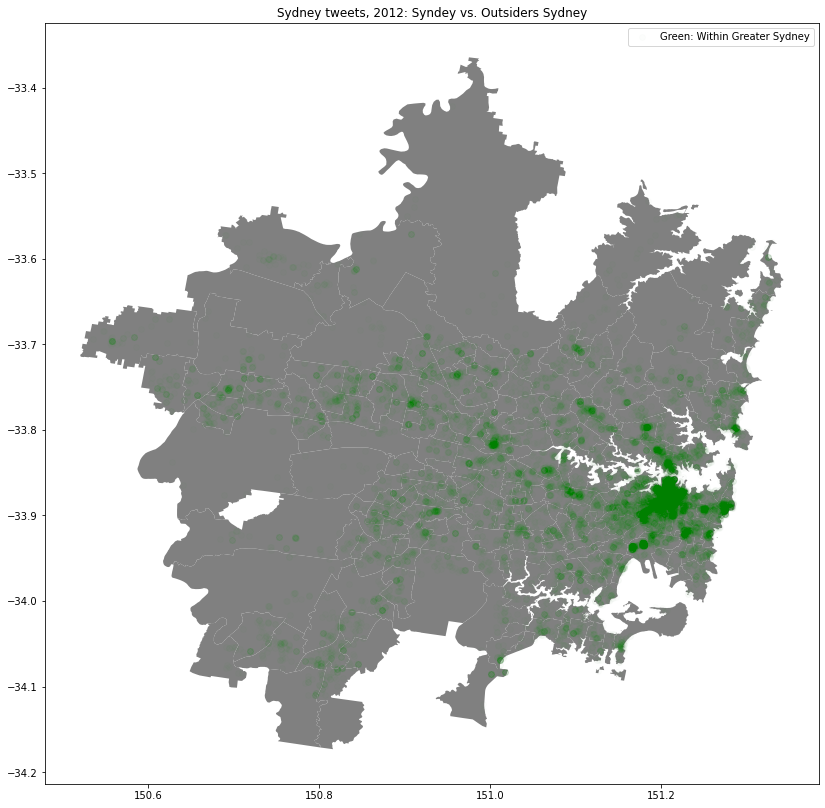

In [141]:
### Plot all 2012 tweets ###
# Green tweets: Joined to an SA2
# Orange tweets: No SA2 Assigned
# Gray: Australia shapefile

fig, ax = plt.subplots(figsize=(20, 14))
syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')
sample = twt2012.sample(frac=.05, random_state=42)
sample[~sample['SA2_MAIN16'].isnull()].plot(ax=ax, marker='o', color='green', alpha=0.01, label='Green: Within Greater Sydney')
sample[sample['SA2_MAIN16'].isnull()].plot(ax=ax, marker='o', color='orange', alpha=0.01, label='Orange: Outside Greater Sydney')
plt.legend()
plt.title('Sydney tweets, 2012: Syndey vs. Outsiders Sydney');

From this, we see that we can use [~autwt_2012['SA2_5DIG16'].isnull()] as a filter to select just the tweets in Syndey, which is our area of interest. For all following analyses, we will restrict the population to just the tweets that fall inside Sydney depicted by the shapefile.

Our first summary statistic computes the ratio of tweets that have a home assignment.

In [142]:
num_home_assigned_tweets = (~twt2012.loc[~twt2012['SA2_MAIN16'].isnull(), 'home'].isnull()).sum()
n_tweets = len(twt2012[~twt2012['SA2_MAIN16'].isnull()])

print("{}/{} = {:.2%} of tweets have a home assignment.".format(
    num_home_assigned_tweets, n_tweets, num_home_assigned_tweets / n_tweets
))

271292/444866 = 60.98% of tweets have a home assignment.


Next, we are interested in the ratio of users that have a home assignment.

In [143]:
num_users_with_home = (~twt2012.loc[~twt2012['SA2_MAIN16'].isnull()].groupby('u_id')['home'].first().isnull()).sum()
n_users = len(twt2012[~twt2012['SA2_MAIN16'].isnull()].groupby('u_id'))

print("{}/{} = {:.2%} of users have a home assignment.".format(
    num_users_with_home, n_users, num_users_with_home / n_users
))

2556/12149 = 21.04% of users have a home assignment.


Lastly, we want to know the ratio of tweets that were made from home (i.e. SA2_5DIG16 and home are equal).

In [144]:
num_tweets_from_home = twt2012.loc[~twt2012['SA2_MAIN16'].isnull(), 'is_home'].sum()

print("{}/{} = {:.2%} of tweets are posted from the home tract.".format(
    num_tweets_from_home, n_tweets, num_tweets_from_home / n_tweets
))

162295/444866 = 36.48% of tweets are posted from the home tract.


Our analysis concludes with a visual representation of this last information; namely, how are the tweets spread out across the entire metropolitan area of Sydney with respect to residence/nonresidence?

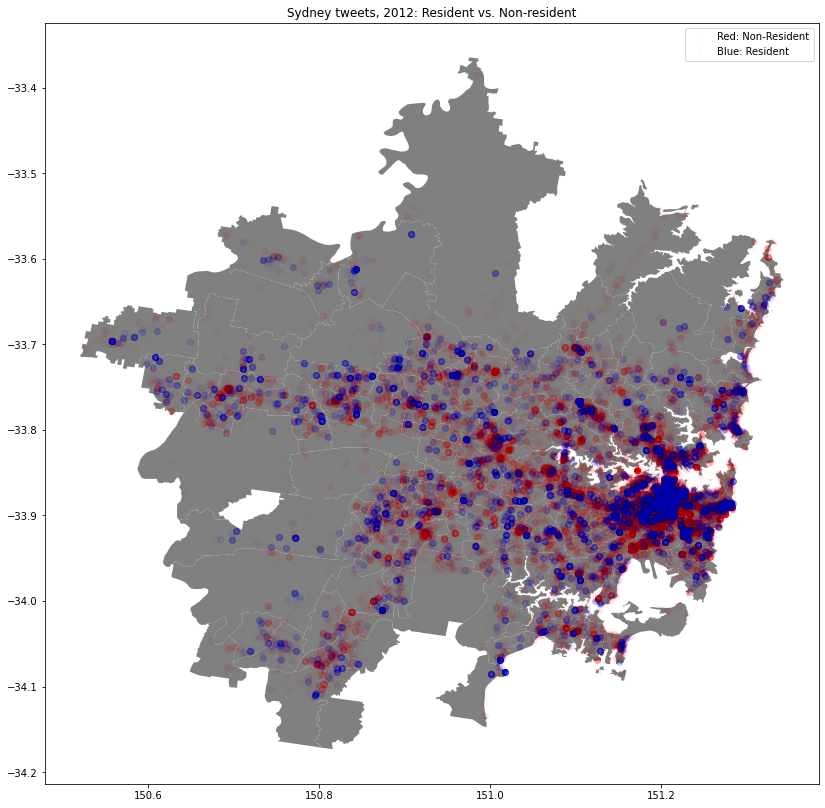

In [145]:
### Plot a 5% sample of 2012 tweets ###
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray: Sydney shapefile

fig, ax = plt.subplots(figsize=(20, 14))

syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

sample = twt2012[~twt2012['SA2_MAIN16'].isnull()].sample(frac=.25, random_state=42)

sample[~sample['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')

sample[sample['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')

plt.legend()
plt.title('Sydney tweets, 2012: Resident vs. Non-resident');

Our analysis concludes with a visual representation of this last information; namely, how are the tweets spread out across the entire metropolitan area of Sydney with respect to residence/nonresidence?

## Join with demographic data and Analyze Case Study Areas

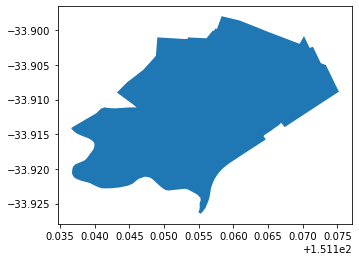

In [146]:
# Read in case study areas
# let's isolate the sa2s that make up our case study areas of Redfern/Waterloo, Marrickville and the Sydenham to 
# Bankstown Corridor
marr_gdf = syd_ucl_sa2[(syd_ucl_sa2.SA2_MAIN16==117021326)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
marr_simple = marr_gdf[['SA2_MAIN16','geometry', "SA4_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
marr_sgdf=marr_simple.dissolve(by="SA4_NAME16")
marr_sgdf.plot()

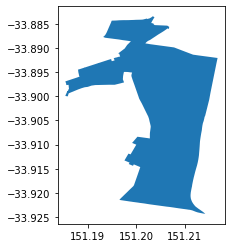

In [147]:
# Read in case study areas
# let's isolate the sa2s that make up our case study areas of Redfern/Waterloo, Merrickville and Maroubra
red_wat_gdf = syd_ucl_sa2[(syd_ucl_sa2.SA2_MAIN16==117031335)
                          |(syd_ucl_sa2.SA2_MAIN16==117031338)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
red_wat_simple = red_wat_gdf[['SA2_MAIN16','geometry', "SA4_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
red_wat_sgdf=red_wat_simple.dissolve(by="SA4_NAME16")
red_wat_sgdf.plot()

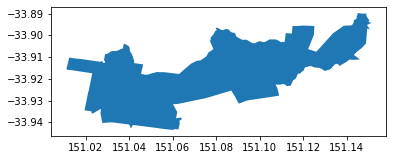

In [148]:
# let's isolate the sa2s that make up our case study areas of Redfern/Waterloo, Merrickville and Maroubra
t3_corr_gdf = syd_ucl_sa2[(syd_ucl_sa2.SA2_MAIN16==120031394)
                          |(syd_ucl_sa2.SA2_MAIN16==120031392)
                          |(syd_ucl_sa2.SA2_MAIN16==119021363)
                          |(syd_ucl_sa2.SA2_MAIN16==119021362)
                          |(syd_ucl_sa2.SA2_MAIN16==119021573)
                          |(syd_ucl_sa2.SA2_MAIN16==119021574)
                          |(syd_ucl_sa2.SA2_MAIN16==119021366)
                          |(syd_ucl_sa2.SA2_MAIN16==119011572)
                          |(syd_ucl_sa2.SA2_MAIN16==119011571)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
t3_corr_simple = t3_corr_gdf[['SA2_MAIN16','geometry', "GCC_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
t3_corr_sgdf=t3_corr_simple.dissolve(by="GCC_NAME16")
t3_corr_sgdf.plot()

### Read in demographic data

The two most important variables that we're going to be looking at are educational attainment and income. Our research has used lower educated SA2s (

* **Low-Income:** Defined as SA2s where the percent of households with weekly income in the bottom two quintiles (bottom 40%) for the region exceeds the regional median SA2 percent in 2011 (41.4%). (The bottom 40% of weekly household income includes those earning below 1,250 per week (2011 Australian dollars).)
 * *The “bottom 40%” income bracket for 2011 includes the bottom 42.6% of households reporting weekly income, based on where the income ranges fall in the census*
 
 
* **Educational Attainment Delta:** The percent change in the percent of adults age 25 years and older whose highest educational attainment is a Bachelor degree or higher exceeds the regional median SA2 percent change from 2011 to 2016 (+11.6%)


* **Change in Professional Type:** The percent change in the percent of adults age 15 years and older whose occupation is Manager or Professional exceeds the regional median SA2 percent change from 2011 to 2016 (+3.4%). 

In [149]:
# read in data with SA2s and low-income tract dummy variables
low_inc = pd.read_csv(dv_analysis_path/'lowincomes.csv')
low_inc.drop(['Unnamed: 0','red_wat_dv','marrick_dv'],axis=1,inplace=True)

# read in data with SA2s and managerial profession delta dummy variables
prof_delta = pd.read_csv(dv_analysis_path/'managers.csv')
prof_delta.drop(['Unnamed: 0','red_wat_dv','marrick_dv'],axis=1,inplace=True)

# read in data with SA2s and managerial profession delta dummy variables
edu_delta = pd.read_csv(dv_analysis_path/'bachelors.csv')
edu_delta.drop(['Unnamed: 0','red_wat_dv','marrick_dv'],axis=1,inplace=True)

In [150]:
# merge twitter data with low-income indicator variables 
twt2012 = pd.merge(twt2012,low_inc,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

In [151]:
# merge twitter data with managerial indicator variables 
twt2012 = pd.merge(twt2012,prof_delta,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

# merge twitter data with managerial indicator variables 
twt2012 = pd.merge(twt2012,edu_delta,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

# remove unecessary variables
twt2012.drop(['SA2_MAINCODE_2016_x','SA2_MAINCODE_2016_y','SA2_MAINCODE_2016'],axis=1,inplace=True)

### Defining a "Privileged" user:

We now have information regarding if the user: 

* Has a home assigned to them 
* If they are from a tract that is not low income 
* If they are from a highly educated tract 
* if they are from a tract with a high proportion of professionals

So now we need to create one more variable that combines all of these factors so that we can see where these people spend their time tweeting.

In [152]:
twt2012.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 444866 entries, 0 to 444865
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    444866 non-null  int64         
 1   created_at            444866 non-null  float64       
 2   text                  444866 non-null  object        
 3   u_id                  444866 non-null  int64         
 4   u_created_at          444866 non-null  float64       
 5   type                  444866 non-null  object        
 6   c_country             444866 non-null  object        
 7   timestamp             444866 non-null  datetime64[ns]
 8   date                  444866 non-null  object        
 9   geometry              444866 non-null  geometry      
 10  index_right           444866 non-null  float64       
 11  SA2_MAIN16            444866 non-null  float64       
 12  SA2_5DIG16            444866 non-null  object     

In [153]:
# create new indicator variable that shows privilege indicators above

twt2012['priv_nh_dv'] = np.where(((twt2012.home.notnull())# Where a tract has a home assignment
                              & (twt2012.is_home==0) # Where the tweet is not in their home tract
                              & (twt2012.lowinc_11_dv==0) # AND their tract is not low-income
                              & (twt2012.mgr_11_dv==1) # AND their tract has a high proportion of professionals
                              & (twt2012.bach_11_dv==1)) # AND their tract is highly educated
                              ,1,0)  # return 1 if True, 0 if False

twt2012['priv_h_dv'] = np.where(((twt2012.home.notnull())# Where a tract has a home assignment
                              & (twt2012.is_home==1)
                              & (twt2012.lowinc_11_dv==0) # AND their tract is not low-income
                              & (twt2012.mgr_11_dv==1) # AND their tract has a high proportion of professionals
                              & (twt2012.bach_11_dv==1)) # AND their tract is highly educated
                              ,1,0)  # return 1 if True, 0 if False

priv_nh_twt_pct = (twt2012['priv_nh_dv'].sum()/len(twt2012))*100
priv_h_twt_pct = (twt2012['priv_h_dv'].sum()/len(twt2012))*100

print("A total of", twt2012['priv_nh_dv'].sum(), 
      "/",
      len(twt2012),
      "are from tracts that are privileged that are not within their assigned home tract. That equates to approximately",
      round(priv_nh_twt_pct,2),
      "% of all tweets in the year 2012.")


print("")

print("A total of", 
      twt2012['priv_h_dv'].sum(), 
      "/",
      len(twt2012),
      "are from tracts that are privileged that are within their assigned home tract. That equates to approximately",
      round(priv_h_twt_pct,2),
      "% of tweets in the year 2012.")

A total of 6535 / 444866 are from tracts that are privileged that are not within their assigned home tract. That equates to approximately 1.47 % of all tweets in the year 2012.

A total of 12960 / 444866 are from tracts that are privileged that are within their assigned home tract. That equates to approximately 2.91 % of tweets in the year 2012.


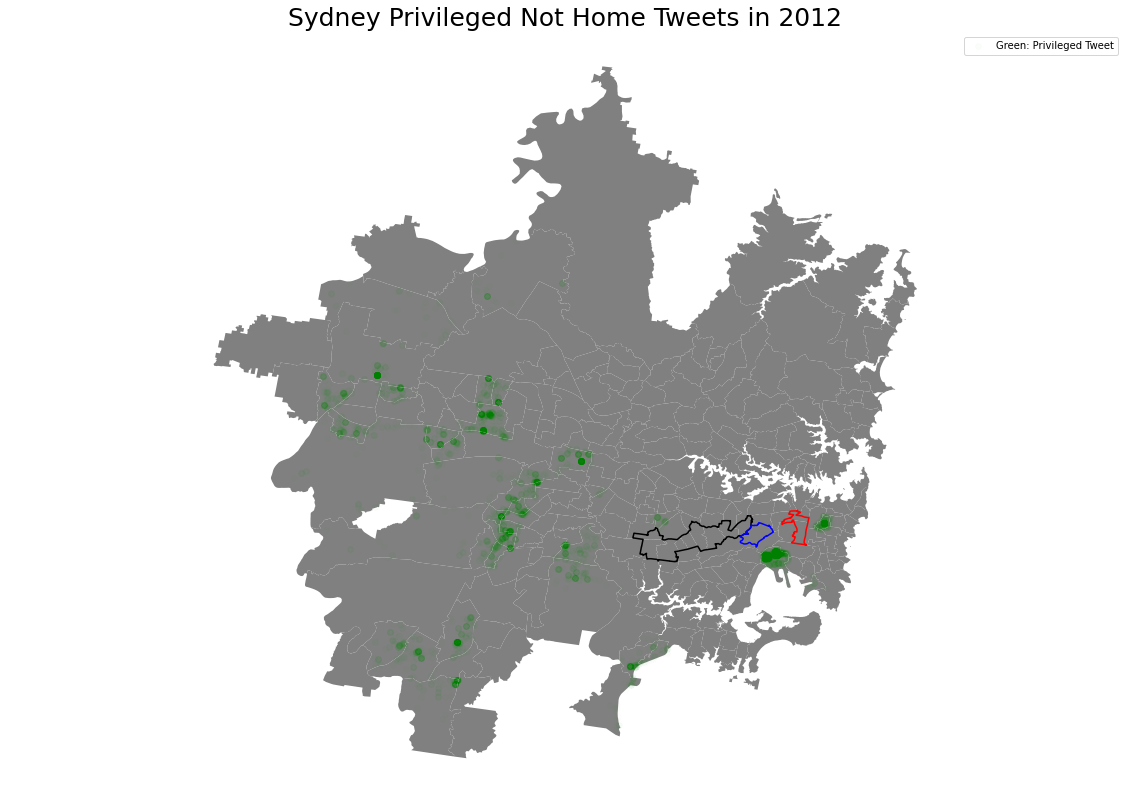

In [154]:
### Plot privileged 2012 tweets where individuals are not in home tract###
# Green tweets: Home tract is "privileged"
fig, ax = plt.subplots(figsize=(20, 14))

base = syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Red", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Blue", linewidth = 1.5)


twt2012[twt2012['priv_nh_dv']==1].plot(ax=ax, marker='o', color='green', alpha=0.01, label='Green: Privileged Tweet')

plt.legend()

lims=plt.axis('equal')
ax.set_axis_off()

plt.title('Sydney Privileged Not Home Tweets in 2012', 
             fontdict={'fontsize':25});

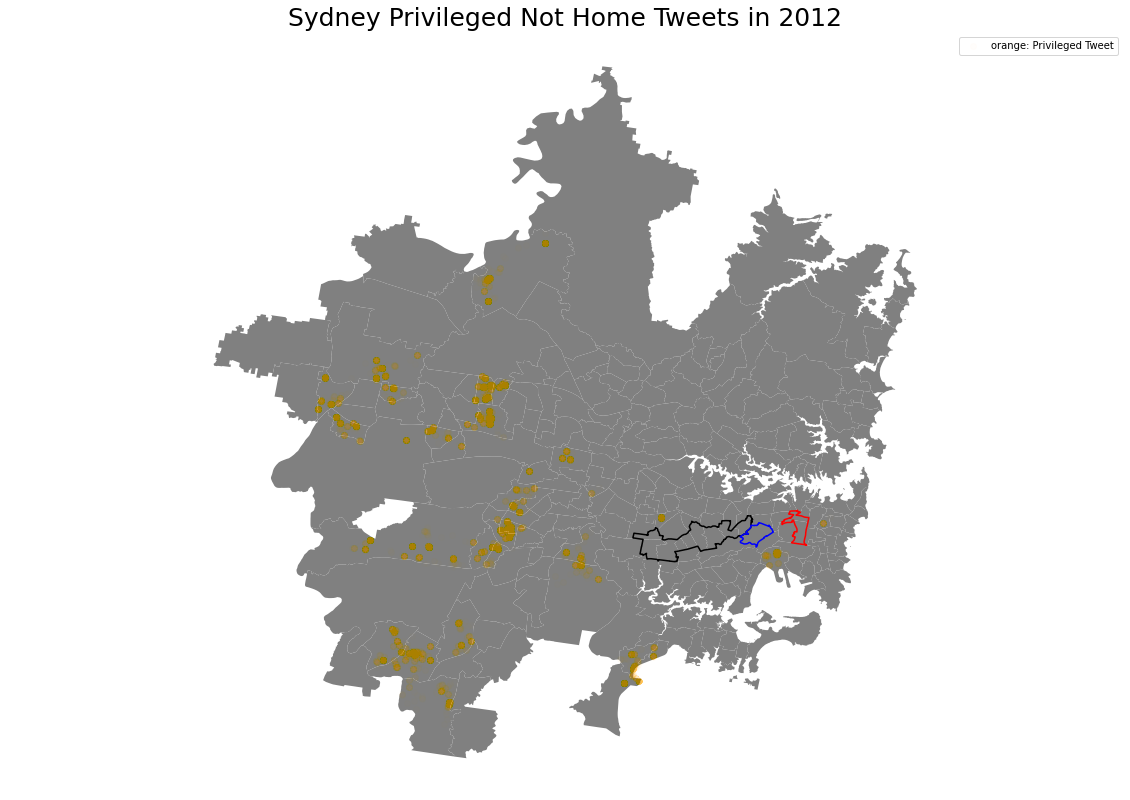

In [155]:
### Plot privileged 2012 tweets where individuals are not in home tract###
# Green tweets: Home tract is "privileged"
fig, ax = plt.subplots(figsize=(20, 14))

base = syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Red", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Blue", linewidth = 1.5)


twt2012[twt2012['priv_h_dv']==1].plot(ax=ax, marker='o', color='orange', alpha=0.01, label='orange: Privileged Tweet')

plt.legend()

lims=plt.axis('equal')
ax.set_axis_off()

plt.title('Sydney Privileged Not Home Tweets in 2012', 
             fontdict={'fontsize':25});

### Defining a "Disadvantaged" user:

We now have information regarding if the user: 

* Has a home assigned to them 
* If they are from a tract that is low income 
* If they are not from a highly educated tract 
* if they are not from a tract with a high proportion of professionals

So now we need to create one more variable that combines all of these factors so that we can see where these people spend their time tweeting.

In [156]:
# create new indicator variable that shows disadvantage indicators above

twt2012['disad_nh_dv'] = np.where(((twt2012.home.notnull())# Where a tract has a home assignment
                              & (twt2012.is_home==False) # Where the tweet is not in their home tract
                              & (twt2012.lowinc_11_dv==1) # AND their tract is not low-income
                              & (twt2012.mgr_11_dv==0) # AND their tract has a high proportion of professionals
                              & (twt2012.bach_11_dv==0)) # AND their tract is highly educated
                              ,1,0)  # return 1 if True, 0 if False

twt2012['disad_h_dv'] = np.where(((twt2012.home.notnull())# Where a tract has a home assignment
                              & (twt2012.is_home==True)# Where the tweet is in their home tract
                              & (twt2012.lowinc_11_dv==1) # AND their tract is not low-income
                              & (twt2012.mgr_11_dv==0) # AND their tract has a high proportion of professionals
                              & (twt2012.bach_11_dv==0)) # AND their tract is highly educated
                              ,1,0)  # return 1 if True, 0 if False

disad_nh_twt_pct = (twt2012['disad_nh_dv'].sum()/len(twt2012))*100
disad_h_twt_pct = (twt2012['disad_h_dv'].sum()/len(twt2012))*100

print("A total of", twt2012['disad_nh_dv'].sum(), 
      "/",
      len(twt2012),
      "are from tracts that are disadvantaged that are not within their assigned home tract. That equates to approximately",
      round(disad_nh_twt_pct,2),
      "% of all tweets in the year 2012.")


print("")

print("A total of", 
      twt2012['disad_h_dv'].sum(), 
      "/",
      len(twt2012),
      "are from tracts that are disadvantaged that are within their assigned home tract. That equates to approximately",
      round(disad_h_twt_pct,2),
      "% of tweets in the year 2012.")

A total of 40179 / 444866 are from tracts that are disadvantaged that are not within their assigned home tract. That equates to approximately 9.03 % of all tweets in the year 2012.

A total of 52468 / 444866 are from tracts that are disadvantaged that are within their assigned home tract. That equates to approximately 11.79 % of tweets in the year 2012.


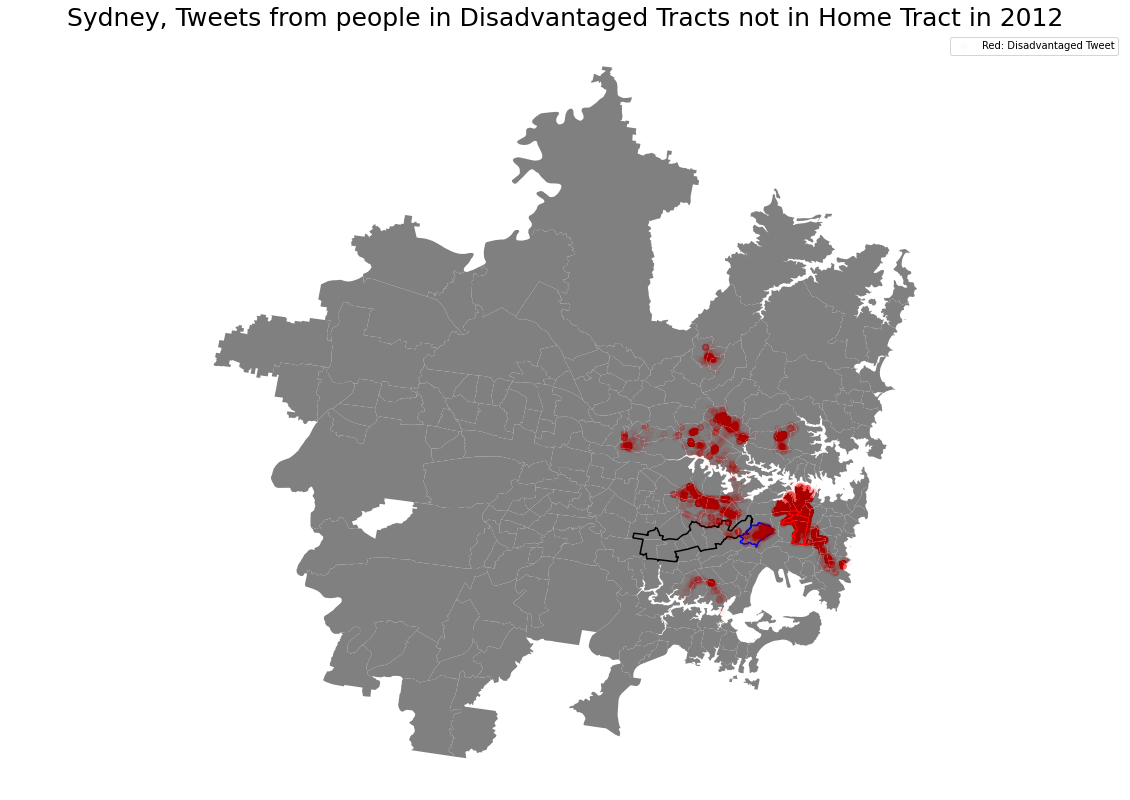

In [157]:
### Plot Disadvantaged 2012 tweets where individuals are not in home tract###
# Red tweets: Home tract is "Disadvantaged"
fig, ax = plt.subplots(figsize=(20, 14))

base = syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Red", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Blue", linewidth = 1.5)

twt2012[twt2012['disad_nh_dv']==1].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Disadvantaged Tweet')

plt.legend()

lims=plt.axis('equal')
ax.set_axis_off()

plt.title('Sydney, Tweets from people in Disadvantaged Tracts not in Home Tract in 2012', 
             fontdict={'fontsize':25});

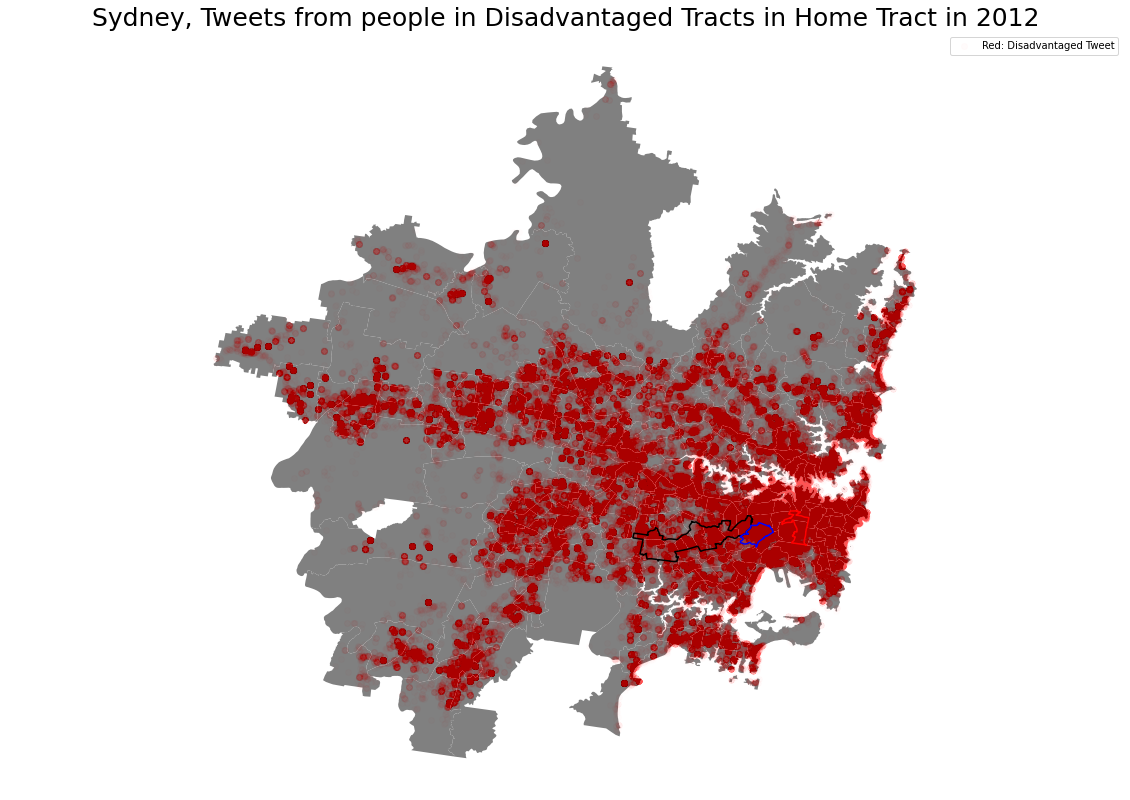

In [163]:
### Plot Disadvantaged 2012 tweets where individuals are not in home tract###
# Red tweets: Home tract is "Disadvantaged"
fig, ax = plt.subplots(figsize=(20, 14))

base = syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

twt2012[twt2012['disad_h_dv']==0].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Disadvantaged Tweet')

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Red", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Blue", linewidth = 1.5)

plt.legend()

lims=plt.axis('equal')
ax.set_axis_off()

plt.title('Sydney, Tweets from people in Disadvantaged Tracts in Home Tract in 2012', 
             fontdict={'fontsize':25});

### Plot the distribution of non-outsider tweets from individuals from poor SA2s that are not within their home tract

In [159]:
twt2012['poor_nh_dv'] = np.where(((twt2012.home.notnull())# Where a tract has a home assignment
                              & (twt2012.is_home==0) # Where the tweet is not in their home tract
                              & (twt2012.lowinc_11_dv==1)) # AND their tract is low-income
                              ,1,0)  # return 1 if True, 0 if False

poor_nh_twt_pct = (twt2012['poor_nh_dv'].sum()/len(twt2012))*100

print("A total of", twt2012['poor_nh_dv'].sum(), 
      "/",
      len(twt2012),
      "are from tracts that are poor that are not within their assigned home tract. That equates to approximately",
      round(poor_nh_twt_pct,2),
      "% of all tweets in the year 2012.")

A total of 61105 / 444866 are from tracts that are poor that are not within their assigned home tract. That equates to approximately 13.74 % of all tweets in the year 2012.


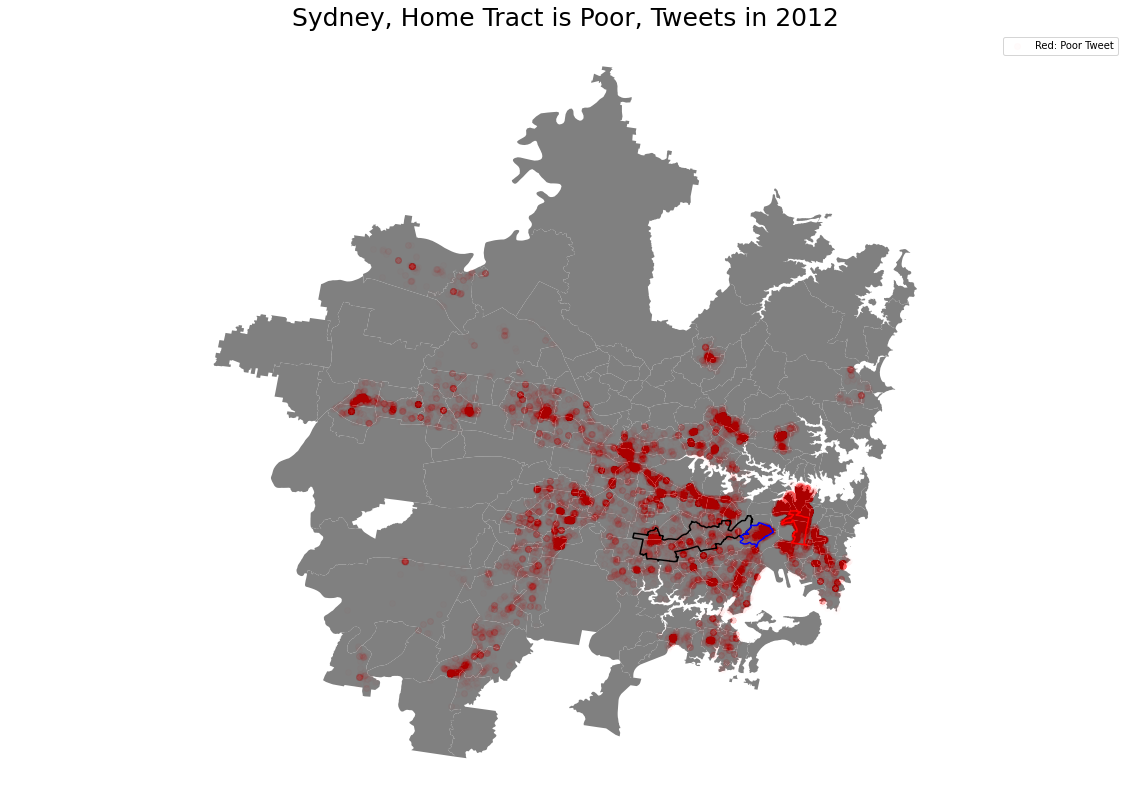

In [168]:
### Plot privileged 2012 tweets where individuals are not in home tract###
# Green tweets: Home tract is "privileged"
fig, ax = plt.subplots(figsize=(20, 14))

base = syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

twt2012[twt2012['poor_nh_dv']==1].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Poor Tweet')

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Red", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Blue", legend=True , linewidth = 1.5)

plt.legend()

lims=plt.axis('equal')
ax.set_axis_off()

plt.title('Sydney, Home Tract is Poor, Tweets in 2012', 
             fontdict={'fontsize':25});

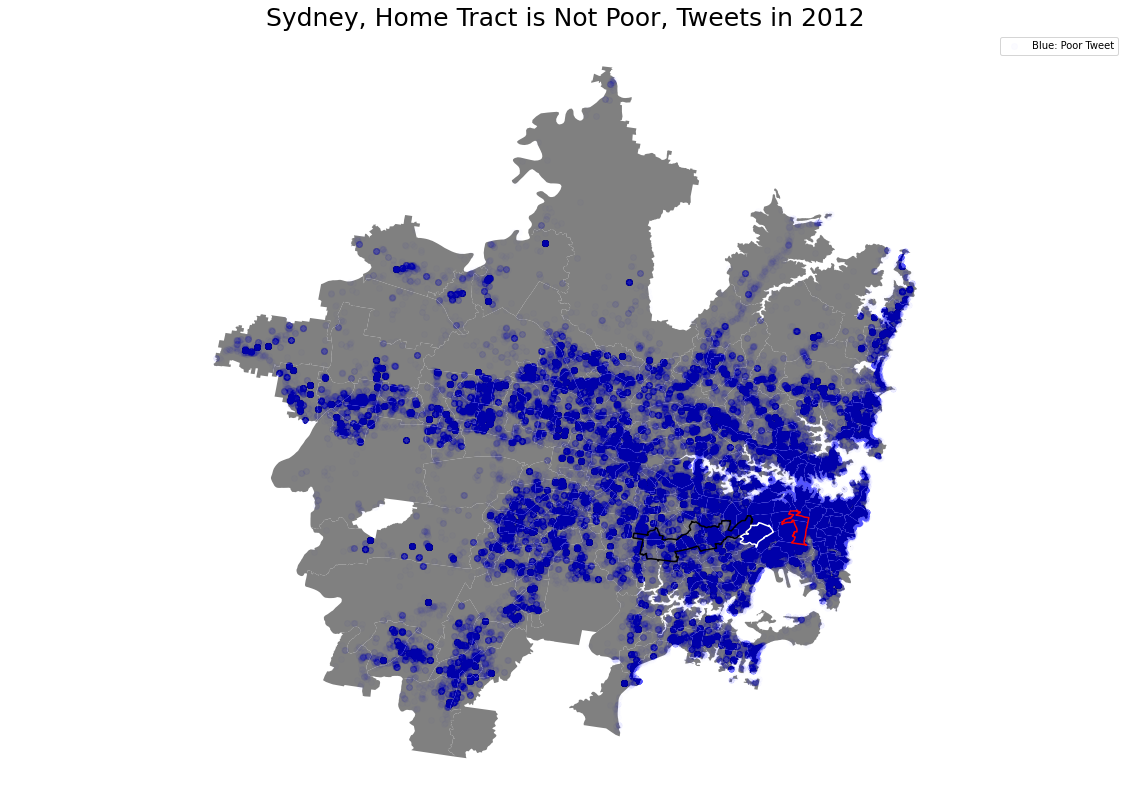

In [167]:
### Plot privileged 2012 tweets where individuals are not in home tract###
# Blue tweets: Home tract is not low income
fig, ax = plt.subplots(figsize=(20, 14))

base = syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

twt2012[twt2012['poor_nh_dv']==0].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Poor Tweet')

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Red", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "White", legend = True, linewidth = 1.5)

plt.legend()

lims=plt.axis('equal')
ax.set_axis_off()

plt.title('Sydney, Home Tract is Not Poor, Tweets in 2012', 
             fontdict={'fontsize':25});

### Plot the distribution of non-outsider tweets from individuals from highly educated SA2s that are not within their home tract

In [176]:
# create a dv for individuals from highly educated tracts
twt2012['edu_nh_dv'] = np.where(((twt2012.home.notnull())# Where a tract has a home assignment
                              & (twt2012.is_home==0) # Where the tweet is not in their home tract
                              & (twt2012.bach_11_dv==1)) # AND their tract is highly educated
                              ,1,0)  # return 1 if True, 0 if False


edu_nh_twt_pct = (twt2012['edu_nh_dv'].sum()/len(twt2012))*100

print("A total of", twt2012['edu_nh_dv'].sum(), 
      "/",
      len(twt2012),
      "are from tracts that are poor that are not within their assigned home tract. That equates to approximately",
      round(edu_nh_twt_pct,2),
      "% of all tweets in the year 2012.")


A total of 24371 / 444866 are from tracts that are poor that are not within their assigned home tract. That equates to approximately 5.48 % of all tweets in the year 2012.


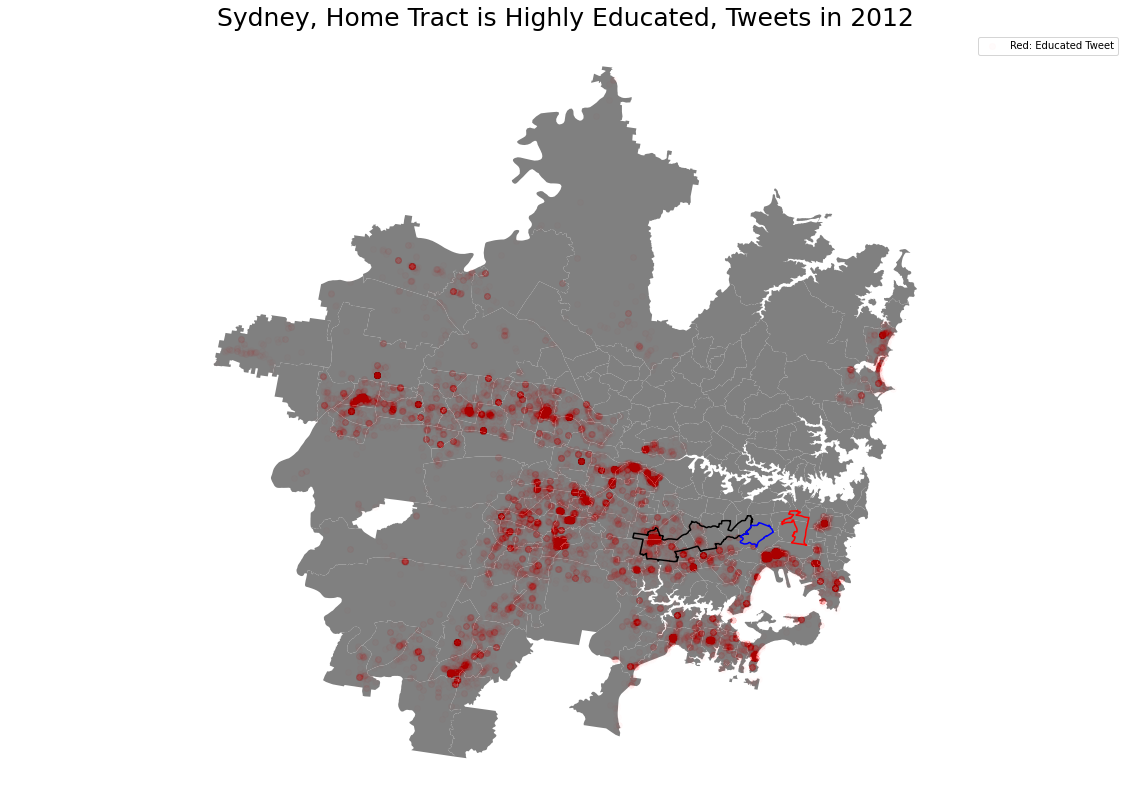

In [177]:
### Plot highly educated 2012 tweets where individuals are not in home tract###
# Green tweets: Home tract has a bachelors degree or higher
fig, ax = plt.subplots(figsize=(20, 14))

base = syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')

twt2012[twt2012['edu_nh_dv']==1].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Educated Tweet')

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Red", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Blue", legend=True , linewidth = 1.5)

plt.legend()

lims=plt.axis('equal')
ax.set_axis_off()

plt.title('Sydney, Home Tract is Highly Educated, Tweets in 2012', 
             fontdict={'fontsize':25});

### Build shapes for the above demographic information to create outlines in mapping

In order to properly see the distribution of tweets and whether they were committed into low-income/low educated areas, etc, we need to find out where these places are by creating boundary shapefiles around each area. Let's create simple gdfs out of each one so that we can create maps for each shape. 

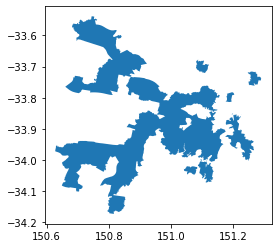

In [178]:
# create polygons for low income areas by merging the shapefile dataframe with the low-income indicator variables
lowinc_shape = pd.merge(syd_ucl_sa2,low_inc,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

# let's isolate the sa2s that make up our that have low-income tracts
lowinc_gdf = lowinc_shape[(lowinc_shape.lowinc_11_dv==1)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
lowinc_simple = lowinc_gdf[['SA2_MAIN16','geometry', "GCC_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
lowinc_sgdf=lowinc_simple.dissolve(by="GCC_NAME16")
lowinc_sgdf.plot()

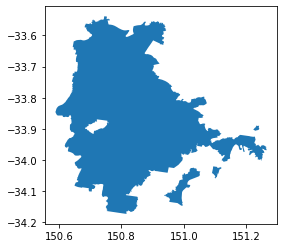

In [179]:
# create polygons for places with high proportion of professionals by merging the shapefile dataframe with the 
# increase in managerial/professional indicator variables
prof_shape = pd.merge(syd_ucl_sa2,prof_delta,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

# let's isolate the sa2s that make up our that have low-income tracts
prof_gdf = prof_shape[(prof_shape.mgr_11_dv==1)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
prof_simple = prof_gdf[['SA2_MAIN16','geometry', "GCC_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
prof_sgdf=prof_simple.dissolve(by="GCC_NAME16")
prof_sgdf.plot()

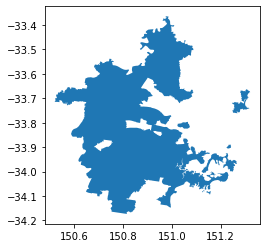

In [180]:
# create polygons for places with high proportion of highly educated people by merging the shapefile dataframe 
# with the bachelor's or higher indicator variables
edu_shape = pd.merge(syd_ucl_sa2,edu_delta,how='left',left_on='SA2_MAIN16',right_on='SA2_MAINCODE_2016').copy()

# let's isolate the sa2s that make up our that have low-income tracts
edu_gdf = edu_shape[(edu_shape.bach_11_dv==1)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
edu_simple = edu_gdf[['SA2_MAIN16','geometry', "GCC_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
edu_sgdf=edu_simple.dissolve(by="GCC_NAME16")
edu_sgdf.plot()

### Groupby SA2 with tweets that are made within home assignments and outside home assignments

The purpose of this grouping is to get insider vs outsider tweets and to then get view the distrbution along those tweets spatially 

In [181]:
# subset the tweets that do not have a home assignment and classify them as "outsider tweets"
out_twt2012 = twt2012[twt2012.home.isnull()]

# create a groupby statement that groups all of the tweets by SA2 so that we can create a choropleth of the 
# distribution
out_twt2012 = pd.DataFrame(out_twt2012.groupby('SA2_MAIN16')['id'].agg('count'))

# merge the dataframe with the sydney shapefile so that we can add the tweet count column 
out_twt2012 = pd.merge(syd_ucl_sa2,out_twt2012, how='left', on='SA2_MAIN16')
out_twt2012.rename(columns={'id':'tweet_count'},inplace=True)
out_twt2012.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   SA2_MAIN16   265 non-null    int32   
 1   SA2_5DIG16   265 non-null    object  
 2   SA2_NAME16   265 non-null    object  
 3   SA3_CODE16   265 non-null    object  
 4   SA3_NAME16   265 non-null    object  
 5   SA4_CODE16   265 non-null    object  
 6   SA4_NAME16   265 non-null    object  
 7   GCC_CODE16   265 non-null    object  
 8   GCC_NAME16   265 non-null    object  
 9   STE_CODE16   265 non-null    object  
 10  STE_NAME16   265 non-null    object  
 11  AREASQKM16   265 non-null    float64 
 12  geometry     265 non-null    geometry
 13  red_wat_dv   265 non-null    int64   
 14  marrick_dv   265 non-null    int64   
 15  t3_corr_dv   265 non-null    int64   
 16  tweet_count  265 non-null    int64   
dtypes: float64(1), geometry(1), int32(1), int64(4), object(10)
memory

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


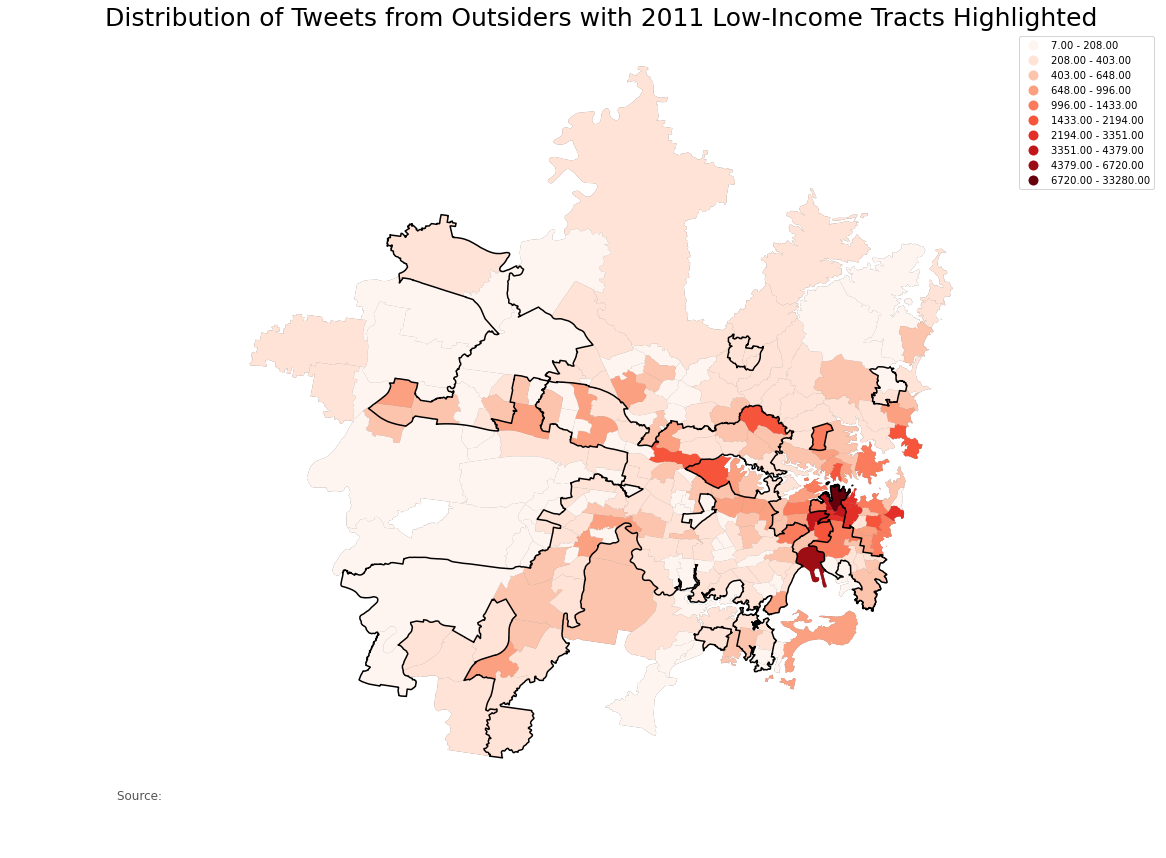

In [182]:
fig, ax = plt.subplots(figsize=(20, 14))
syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')
base = out_twt2012.plot(column="tweet_count", scheme = "fisher_jenks", k = 10, legend=True, ax=ax, cmap="Reds")

lowinc_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)

lims=plt.axis('equal')
ax.set_axis_off()

ax.set_title('Distribution of Tweets from Outsiders with 2011 Low-Income Tracts Highlighted', 
             fontdict={'fontsize':25})

ax.annotate('Source: ',
            xy=(0.1, .08),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, 
            color='#555555')

plt.show()

In [183]:
# subset the tweets that do not have a home assignment and classify them as "outsider tweets"
in_twt2012 = twt2012[twt2012.home.notnull()]

# create a groupby statement that groups all of the tweets by SA2 so that we can create a choropleth of the 
# distribution
in_twt2012 = pd.DataFrame(in_twt2012.groupby('SA2_MAIN16')['id'].agg('count'))

# merge the dataframe with the sydney shapefile so that we can add the tweet count column 
in_twt2012 = pd.merge(syd_ucl_sa2,in_twt2012, how='left', on='SA2_MAIN16')
in_twt2012.rename(columns={'id':'tweet_count'},inplace=True)
in_twt2012.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   SA2_MAIN16   265 non-null    int32   
 1   SA2_5DIG16   265 non-null    object  
 2   SA2_NAME16   265 non-null    object  
 3   SA3_CODE16   265 non-null    object  
 4   SA3_NAME16   265 non-null    object  
 5   SA4_CODE16   265 non-null    object  
 6   SA4_NAME16   265 non-null    object  
 7   GCC_CODE16   265 non-null    object  
 8   GCC_NAME16   265 non-null    object  
 9   STE_CODE16   265 non-null    object  
 10  STE_NAME16   265 non-null    object  
 11  AREASQKM16   265 non-null    float64 
 12  geometry     265 non-null    geometry
 13  red_wat_dv   265 non-null    int64   
 14  marrick_dv   265 non-null    int64   
 15  t3_corr_dv   265 non-null    int64   
 16  tweet_count  265 non-null    int64   
dtypes: float64(1), geometry(1), int32(1), int64(4), object(10)
memory

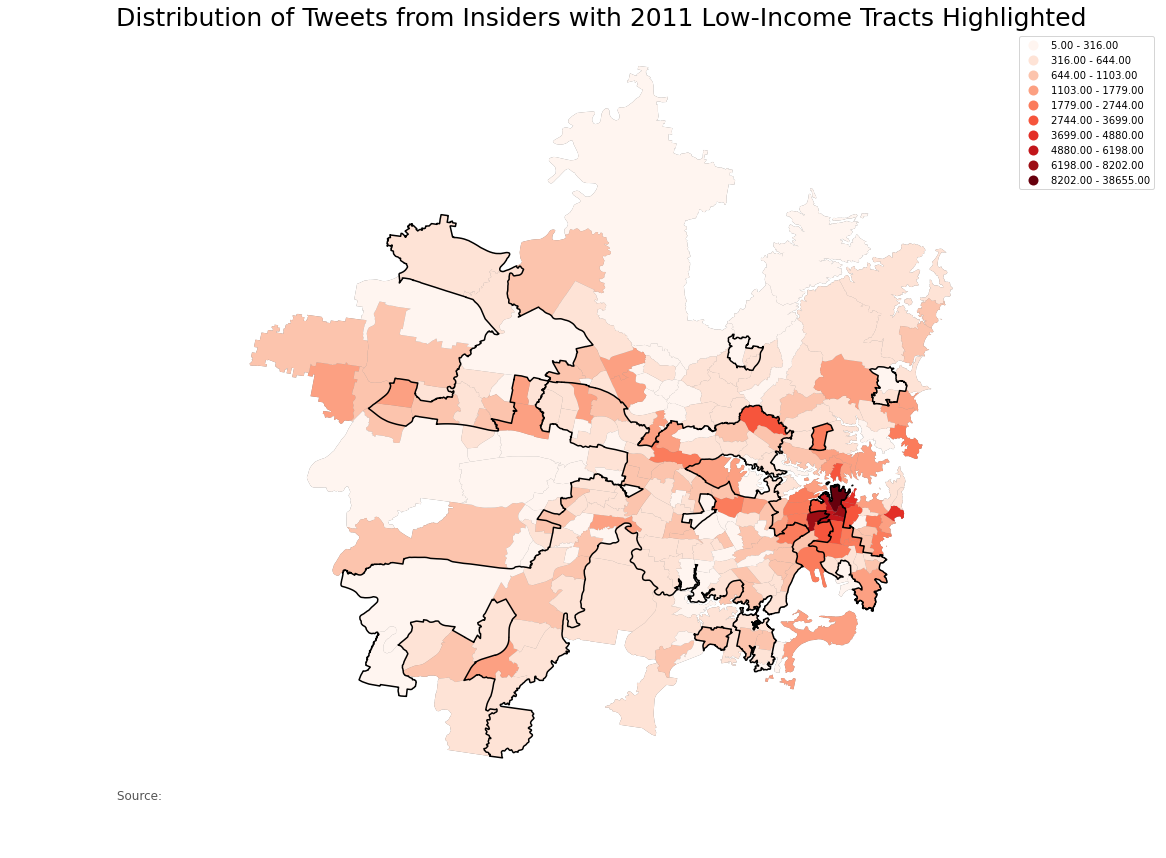

In [184]:
fig, ax = plt.subplots(figsize=(20, 14))
syd_ucl_sa2['geometry'].plot(ax=ax, color='gray')
base = in_twt2012.plot(column="tweet_count", scheme = "fisher_jenks", k = 10, legend=True, ax=ax, cmap="Reds")

lowinc_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)

lims=plt.axis('equal')
ax.set_axis_off()

ax.set_title('Distribution of Tweets from Insiders with 2011 Low-Income Tracts Highlighted', 
             fontdict={'fontsize':25})

ax.annotate('Source: ',
            xy=(0.1, .08),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, 
            color='#555555')

plt.show()